In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy as sc
import scipy.ndimage as scimg
from scipy.optimize import minimize
import psana as ps
from matplotlib import pyplot as plt
from tqdm import tqdm
import matplotlib.colors as colors
from scipy.ndimage import gaussian_filter as gf

from matplotlib import cm
from matplotlib.colors import ListedColormap
from scipy.interpolate import interp1d
import sys
sys.path.append('/reg/neh/home/tdd14/modules/cart2pol/cart2pol')
import cart2pol
import scipy.misc as scmis
from scipy.optimize import curve_fit
import scipy.special as sp
import cv2

from datetime import datetime
sys.path.append('/reg/d/psdm/tmo/tmox51020/results/paris/recon')
from recon_funcs import *

from matplotlib import cm
from matplotlib.colors import ListedColormap
my_cmap = cm.get_cmap('jet')
xr = np.linspace(0, 1, 2000)
my_cmap = my_cmap(xr)
my_cmap[0][-1] = 0
my_cmap = ListedColormap(my_cmap)

/reg/neh/home/tdd14/modules/CPBASEX/pbasex-Python/pbasex/gData.py:55: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if gData['rBF'] is not 'custom':


Hi! I imported. 


In [3]:
mfn = 25
gfn = 15
gfsig = 0.985
basesdir = '/reg/d/psdm/tmo/tmoc00118/results/siqili/basis_functions/'
PR = PolarRebin('/reg/d/psdm/tmo/tmox51020/results/paris/recon/PR_c32_r32_th32.h5')

In [4]:
! ls '/reg/d/psdm/tmo/tmoc00118/results/siqili/'

basis_functions  data  recon  scratch


In [93]:
! ls '/reg/d/psdm/tmo/tmoc00118/results/siqili/basis_functions'

alpha_tdata.npy        Bpbasis_Up_0.1eV.h5
alpha_t.npy	       Bpbasis_Up_0.1eV.npy
alpha_t_sample.npy     Bpbasis_Up_0.25eV.npy
basis_all.mat	       Bpbasis_Up_0.2eV.npy
Bpbasis_Up_0.02eV.npy  Bpbasis_Up_0.3eV.npy
Bpbasis_Up_0.04eV.npy  Bpbasis_Up_0.4eV.npy
Bpbasis_Up_0.05eV.npy  Bpbasis_Up_0.5eV.h5
Bpbasis_Up_0.06eV.npy  Bpbasis_Up_0.5eV.npy
Bpbasis_Up_0.08eV.npy  Bpbasis_Up_0eV.npy
Bpbasis_Up_0.0eV.npy   Bpbasis_Up_0_to_0.5eV_filtered.npy
Bpbasis_Up_0.12eV.npy  tdata.npy
Bpbasis_Up_0.14eV.npy  vNaxis_t.npy
Bpbasis_Up_0.15eV.npy  vNaxis_t_sample.npy
Bpbasis_Up_0.16eV.npy  vNaxis_w.npy
Bpbasis_Up_0.18eV.npy


In [11]:
gfsig = 0 
Ups = [0.0]
Bps = []
alphas = []
vNaxiss = []
alphaws = []
N_w = 6
N_t = 6
Nb = N_w*N_t
for i in range(len(Ups)):
    Np = 128
    Up = Ups[i]  
    filename = 'Bpbasis_Up_' + str(Up)+'eV.npy'
    print(filename)
    BB = np.load(basesdir+filename, allow_pickle=True)
    
    Breal = np.real(BB)
    Bimag = np.imag(BB)
    alpha_t_sample=np.load('/reg/d/psdm/tmo/tmoc00118/results/siqili/basis_functions/alpha_t_sample.npy')
    vNaxis_t=np.load('/reg/d/psdm/tmo/tmoc00118/results/siqili/basis_functions/vNaxis_t.npy')
    vNaxis_t_sample=np.load('/reg/d/psdm/tmo/tmoc00118/results/siqili/basis_functions/vNaxis_t_sample.npy')
    vNaxis_w=np.load('/reg/d/psdm/tmo/tmoc00118/results/siqili/basis_functions/vNaxis_w.npy')
    
    br = np.array({'Breal':Breal, 'Bimag': Bimag, 'vNaxis': {'t':vNaxis_t, 't_sample':vNaxis_t_sample, 'w':vNaxis_w}, 'alpha': {'t_sample':alpha_t_sample}})
   
    
    Breal = br[()]['Breal']
    Bimag = br[()]['Bimag']
    #breal = br[()]['breal']
    #bimag = br[()]['bimag']
    vNaxis = br[()]['vNaxis']
    alpha = br[()]['alpha']

    
    if Breal.shape[0] == 128**2:
        tempr = np.zeros((Breal.shape[0], 64**2))
        tempi = np.zeros((Breal.shape[0], 64**2))
        for i in range(len(Breal)):
            tempr[i,:] = np.reshape(rebin(np.reshape(Breal[i,:], [128,128])), [64**2])
            tempi[i,:] = np.reshape(rebin(np.reshape(Bimag[i,:], [128,128])), [64**2])

        Breal = tempr
        Bimag = tempi

    alphw = np.zeros(alpha['t_sample'].shape, dtype = complex)
    for i in range(len(alphw)):
        f = interp1d(vNaxis['t_sample'], alpha['t_sample'][i], fill_value = 0, bounds_error = False)
        N = 2801 #1024
        ts = np.linspace(vNaxis['t_sample'][0],-vNaxis['t_sample'][0], N)
        alphw[i] = np.fft.ifftshift(np.fft.ifft(f(ts)))

    Np = 64
    for j in range(Breal.shape[0]):
        temp=np.reshape(Breal[j,:],[Np,Np])
        polimg = PR.cart2pol(temp,32,32)
        bb = np.zeros((64,64))
        bb[1:64,1:64]= PR.pol2cart(scimg.filters.gaussian_filter(polimg,[gfsig,0]))
        Breal[j,:]=np.reshape(bb,newshape=(1,Np**2))
        #temp=scimg.filters.gaussian_filter(temp,0.8889)
        #Bpr[j,:]=Variable(Tensor(np.reshape(temp,newshape=(1,Np**2))))
        temp=np.reshape(Bimag[j,:],[Np,Np])
        polimg = PR.cart2pol(temp,32,32)
        bb = np.zeros((64,64))
        bb[1:64,1:64]= PR.pol2cart(scimg.filters.gaussian_filter(polimg,[gfsig,0]))
        Bimag[j,:]=np.reshape(bb,newshape=(1,Np**2))
        #temp=scimg.filters.gaussian_filter(temp,0.8889)
        #Bpi[j,:]=Variable(Tensor(np.reshape(temp,newshape=(1,Np**2))))

    Bp_basis = Breal+1j*Bimag

    Bps.append(Bp_basis)
    alphas.append(alpha)
    vNaxiss.append(vNaxis)
    alphaws.append(alphw)

Bpbasis_Up_0.0eV.npy


/tmp/ipykernel_16725/2624009226.py:57: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  bb[1:64,1:64]= PR.pol2cart(scimg.filters.gaussian_filter(polimg,[gfsig,0]))
/tmp/ipykernel_16725/2624009226.py:64: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  bb[1:64,1:64]= PR.pol2cart(scimg.filters.gaussian_filter(polimg,[gfsig,0]))


In [5]:
from scipy.optimize import minimize

def make_MM(x0):
    xshift, yshift =  x0[8], x0[9] 

    # Coordinates that you want to Perspective Transform
    pts1 = np.float32([[0,0],\
                       [0,1024],\
                       [1024,0],\
                       [1024, 1024]])


    # Size of the Transformed Image
    pts2 = np.float32([[0+xshift-x0[0],0 + yshift-x0[1]],\
                       [0+xshift-x0[2],1024 + yshift-x0[3]],\
                       [1024+xshift-x0[4],0 + yshift-x0[5]],\
                       [1024+xshift-x0[6],1024 + yshift-x0[7]]])

    MM = cv2.getPerspectiveTransform(pts1,pts2)
    return MM

#mask to block bright spots by the hole
x,y, = 530,512
X,Y=np.meshgrid(np.arange(1024),np.arange(1024))
rs=np.sqrt((X-x)**2+(Y-y)**2)
mask=np.zeros((1024,1024))
mask[rs>1*48]=1

In [6]:
MM = make_MM([0,0, 0, 0, 0, 0, 0, 0, 512-535, 512-512])


In [29]:
run.detnames

{'andor',
 'ebeam',
 'epicsinfo',
 'gmd',
 'pcav',
 'timing',
 'tmo_atmopal',
 'tmo_opal1',
 'tmo_opal2',
 'xgmd'}

In [9]:
#tmoc00118, run 286, 289
exp = 'tmoc00118'
runnum = 288 #286 
gmd_min = 0.05
gmd_max = 0.5
gas_jet = 1



In [10]:
nn = 0
ds = ps.DataSource(exp=exp, run=runnum)
run = next(ds.runs())

if hasattr(run, 'epicsinfo'):
    epics_strs = [item[0] for item in run.epicsinfo.keys()][1:] # first one is weird
    epics_detectors = [run.Detector(item) for item in epics_strs]    


# specify detectors here
opal1 = run.Detector('tmo_opal1') # OPAL camera looking at the holey mirror
gmd = run.Detector("gmd") # gas intensity detector 
xgmd = run.Detector("xgmd") # gas intensity detector 
timing = run.Detector('timing') # this gives access to evr codes
ebeam = run.Detector("ebeam")
#spectrometer = run.Detector('tmo_fzpopal') 
spectrometer = run.Detector('andor')



ims_bg = [] # initialize the list of example images here
GDs_bg = []
xGDs_bg = []
specs = []
jet_timing_bg = []


for nevent, event in enumerate(run.events()): # loop over events (shots) in the run

    # fetch the information from the different events
    opal1im_i=np.copy(opal1.raw.raw(event))
    #opal1im_i=np.copy(opal1.raw.image(event)) #doesn't work since update
    gd_i=gmd.raw.energy(event)
    xgd_i=xgmd.raw.energy(event)
    evr=timing.raw.eventcodes(event)
    L3 = ebeam.raw.ebeamL3Energy(event)

    # identify relevant event codes
    gas=evr[70] # did the gas jet fire
    ir_timed=evr[67] # was the ir laser timed
    ir_misttimed=evr[68] # was the ir laser mis-timed

    
    #if opal1im_i is None or gd_i is None or gd_i<gmd_min or (gas != gas_jet): continue
    if opal1im_i is None or gd_i is None or gd_i>gmd_max or gd_i<gmd_min or (gas != gas_jet): continue
    
    data = {'epics_'+epic_str: epic_det(event) for epic_str, epic_det in zip(epics_strs, epics_detectors)}        
    if any(type(val) not in [int, float] for val in data.values()):
        print("Bad EPICS: %d" % nevent)
        #Nbad += 1
        continue
        
        
    if ir_misttimed:
        ims = np.rot90(opal1im_i*mask)
        #ims = ims/np.sum(ims)
        #ims = cv2.warpPerspective(ims,MM,(1024,1024))
        #ims_bg.append(ims[100:900,100:900])
        ims_bg.append(ims)
        GDs_bg.append(gd_i)
        xGDs_bg.append(xgd_i)
        jet_timing_bg.append(data['epics_evr_ch0_delay'])
        
        if spectrometer._det_name == 'andor': #if vls
            spec = np.squeeze(np.copy(spectrometer.raw.value(event)))[1024:]
            spec = np.squeeze(fastsmooth1(spec,20))
            spec = np.array(np.squeeze(spec) - np.mean(np.squeeze(spec)[0:100])) 
            spec[spec<0] = 0
            specs.append(spec)
        else: #if zone plate spec
            opalfz= np.copy(spectrometer.raw.image(event)) #np.copy(opal1.raw.image(event)) #np.copy(opal1.raw.raw(event))
            zps_data = opalfz
            zps_pixel = 100+np.argmax(np.sum(zps_data[100:900],axis=1))
            px_2d_width = 25 #spacing to cut the 2d image slice to store. Typically 50 pixel width. 25 on either side
            px_edge_width = 5 #spacing to integrate for the line out. 

            zps_2d = zps_data[zps_pixel-px_2d_width:zps_pixel+px_2d_width][:]
            zps = zps_data[zps_pixel-px_edge_width:zps_pixel+px_edge_width][:].mean(0)#
            zps_bg = zps_data[zps_pixel-px_2d_width:zps_pixel-px_2d_width+px_edge_width][:].mean(0)#
            zps = zps-zps_bg
            spec = np.squeeze(fastsmooth1(zps,10))
            spec = np.array(np.squeeze(spec) - np.mean(np.squeeze(spec)[800:900])) 
            spec[spec<0] = 0
            specs.append(spec)
        
        
        nn +=1
        
        
    

    if nn%20 == 0:
        print('gathered: %1.0f' %nn)
        
    if len(ims_bg) > 400:
        break
print(len(ims_bg))

gathered: 0
gathered: 20
gathered: 20
gathered: 20
gathered: 20
gathered: 20
gathered: 20
gathered: 20
gathered: 20
31


In [11]:
def px_2_nm(pixel, vls_pitch, order):
    'updated May 8/9 from Dougie'
    pitch_slope = -1.37220068e+03 # negative of pitch shift to px shift proportionality constant
    pitch_0 = 4.98 #The VLS pitch where the calibration is done 
    order_0 = 4
    pitch_diff = pitch_0-vls_pitch
    effective_pixel = pixel + (pitch_slope*pitch_diff)
    # Result of calibration at pitch_0
    #offset, slope = [ 2.37772901e+00, -3.64235449e-04]
    offset, slope, slope_2 =[ 2.38324323e+00, -3.92516982e-04,  1.44317419e-08]
    return (offset + slope*effective_pixel + slope_2*effective_pixel**2)*(order_0/order)

def eV(wavelen):
    'wavelen in nm'
    return 1e2 * 6.64 * 2.99 / (wavelen * 1.6)

In [12]:
#vls_nm=px_2_nm(np.arange(2048), 6, 1)
vls_nm=px_2_nm(np.arange(2048),5.189, 4.)
vls_eV=eV(vls_nm)[1024:]

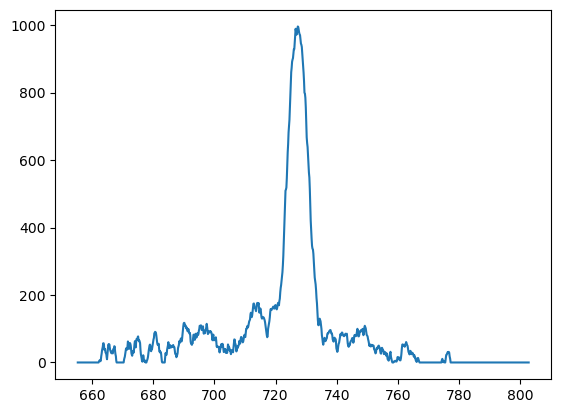

In [13]:
plt.plot(vls_eV, specs[1])

In [102]:
1024/(vls_eV[-1]-vls_eV[0])

6.94630134446204

In [14]:
GDs_bg = np.array(GDs_bg)
xGDs_bg = np.array(xGDs_bg)
ims_bg = np.array(ims_bg)
specs = np.array(specs)
ims_bg.shape

for x,i in enumerate(xGDs_bg):
    if type(xGDs_bg[x]) == type(None):
        xGDs_bg[x] = np.nan 

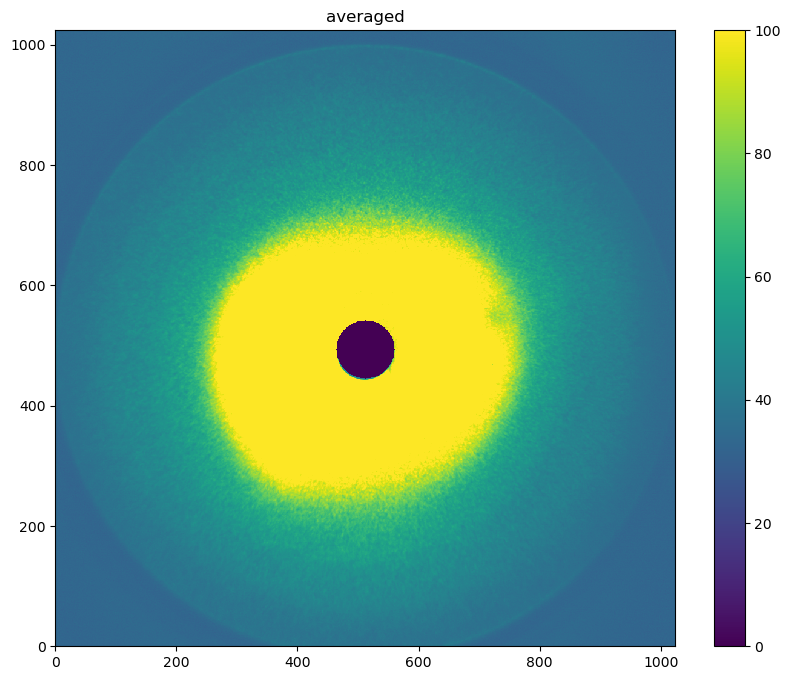

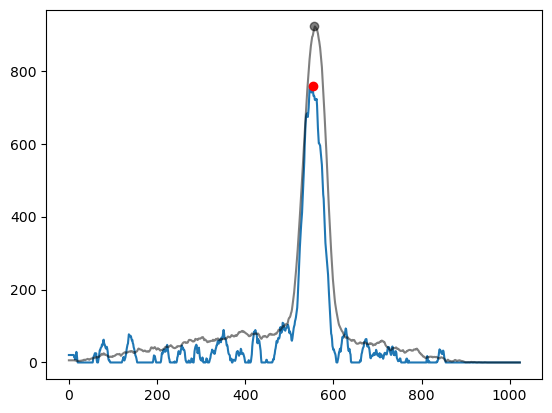

Text(0.5, 1.0, 'roll by -46 in order to center w0 at pixel 512')

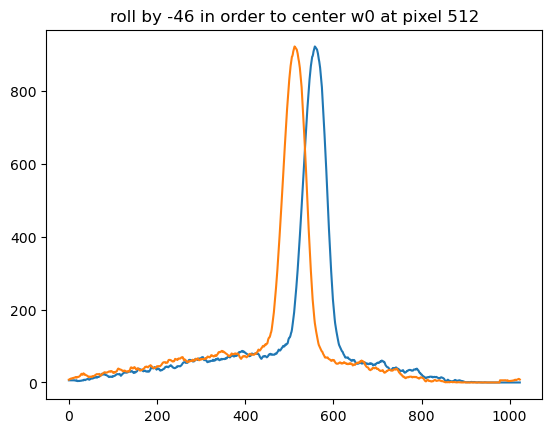

In [15]:
fig,axs = plt.subplots(figsize = (10,8))
ims2plot = np.mean(ims_bg,0)
#ims2plot[ims2plot<30] = 0
plt.pcolormesh((ims2plot), vmax = 100)
plt.colorbar()
plt.title('averaged')
plt.show()

k = 0
plt.plot(specs[k])
plt.plot(get_centroidish(specs[k]), np.max(specs[k]), 'ro')
plt.plot(np.mean(specs,axis = 0), 'k', alpha = 0.5)
plt.plot(get_centroidish(np.mean(specs,axis = 0)), np.max(np.mean(specs,axis = 0)), 'ko', alpha = 0.5)
plt.show()

offset = 512 - np.argmax(np.mean(specs,axis = 0))
plt.plot(np.mean(specs,axis = 0))
plt.plot(np.roll(np.mean(specs,axis = 0), offset))
plt.title('roll by %1.0f in order to center w0 at pixel 512' %offset)

In [16]:
pixpereV = 6.95 #29.471
resid = np.load('bg_run_286_Mar.npy') #dipole bg

N = 2801
xf = np.arange(-N/2+1/2,N/2+1/2,1)/((vNaxis['t_sample'][-1] - vNaxis['t_sample'][0])) #using tsample range
eV = 1239.84*(2*np.pi*xf)/2.9979E8/(2*np.pi)*1e-9 
#Interpolate spec outside of the loop to match eV
xeV = pix_2_eV(np.arange(1024), pixpereV = pixpereV, spectra_hw0 = 0, spectra_pix0 = 512)
f = interp1d(np.arange(1024),xeV,bounds_error=False, fill_value = 0)

In [17]:
centroid = []
for s in specs:
    centroid.append(get_centroidish(np.roll(s, offset))) #rolling to center w0 at center of array, pixel 512

In [18]:
cc = np.copy(centroid)

In [19]:
centroid_eV = np.array([f(x) for x in centroid])

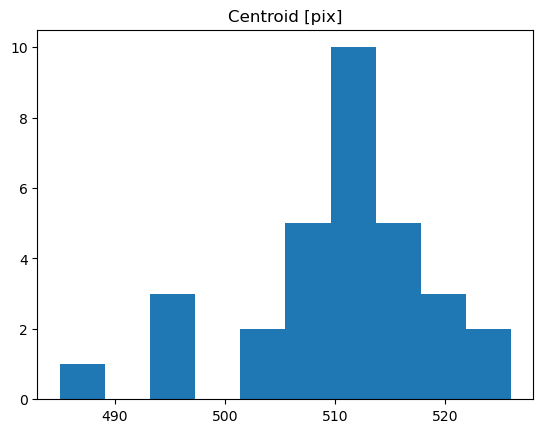

Text(0.5, 1.0, 'Centroid [eV]')

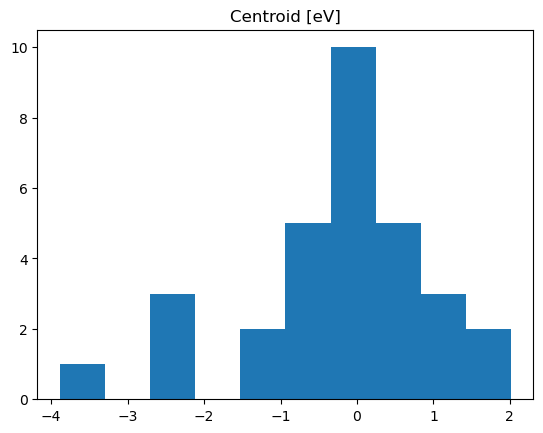

In [20]:
centroid = np.array(centroid)
plt.hist(centroid)
plt.title('Centroid [pix]')
plt.show();
plt.hist(centroid_eV)
plt.title('Centroid [eV]')

In [9]:
sys.path.append('/reg/neh/home/tdd14/modules/CPBASEX/pbasex-Python/pbasex') # any user should be able
# to load from here
from gData import loadG
from pbasex import pbasex
sys.path.append('/reg/neh/home/tdd14/modules/quadrant/quadrant') # any user should be able
# to load from here
from quadrant import foldQuadrant, resizeFolded
from scipy.ndimage.filters import gaussian_filter1d as gf1d
# Load inversion data
#gData = loadG('/reg/d/psdm/amo/amolu0017/results/taran/calc/pbasex/G_r512_k128_l4.h5', 1) #1 flags load array to make images
gData = loadG('/cds/home/p/paris/vNrecon_NN_May_2021/G_r512_k128_l4.h5', 1)
import cv2

/tmp/ipykernel_25955/3186943381.py:8: DeprecationWarning: Please use `gaussian_filter1d` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter1d as gf1d


In [22]:
# define some parameters
x0,y0=512,512 #center of the VMI detector
#vmi_im = bg #np.ones((1024, 1024)) # this can be a 2D array with dimensions (n_pix x n_pix) or a 3D array with dimensions
# (n_pix x n_pix x n_ims)
quadrant_filters=[[1,0,0,0], [0,1,0,0], [0,0,1,0], [0,0,0,1]] # define quadrants
# to use, clockwise from bottom right when full im is plotted with pcolormesh (although
# this plotting behavior should probably be expected to change and should be checked)
ke_calib = lambda x: 2e-4 * x**2 # kinetic energy calibration (if you want to plot with one below)
ke_calib = lambda x: x # you could just have this if you don't have a KE yet

In [23]:
#imsM = [cv2.warpPerspective(ii,MM,(1024,1024)) for ii in ims_bg]
imsM = [cv2.warpPerspective(np.rot90(ii,-1),MM,(1024,1024)) for ii in ims_bg]
print('make sure rotation is right')
resid = cv2.resize(resid, (1024,1024), interpolation = cv2.INTER_AREA)

make sure rotation is right


In [24]:
maskscale = np.zeros((1024,1024))
X,Y=np.meshgrid(np.arange(1024),np.arange(1024))
rs=np.sqrt((X-512)**2+(Y-512)**2)
maskscale[(rs>60) & (rs<150)]=1

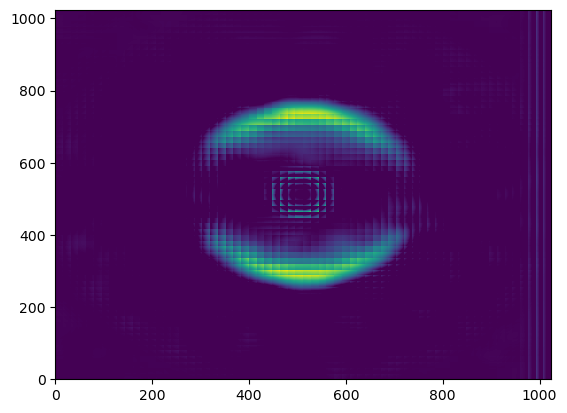

In [25]:
ims2 = gf(mf(imsM[0],25),15) 
resid_scale = resid/np.mean(resid*maskscale)*np.mean(ims2*maskscale)
s = ims2
mm = s-resid_scale
mm[mm<0] = 0
plt.pcolormesh(mm)

In [26]:
X,Y=np.meshgrid(np.arange(1024),np.arange(1024))
rs=np.sqrt((X-512)**2+(Y-512)**2)
maskhm=np.zeros((1024,1024))
maskhm[(rs>100) & (rs<420)]=1

In [27]:
quadrant_filters=[[1,0,0,0], [0,1,0,0], [0,0,1,0], [0,0,0,1], [1,1,1,1]] #, [1,1,1,0], [1,0,0,1]]
n = len(ims_bg)
rrs = [] #np.zeros((n,len(quadrant_filters)))
nns = []
maxes = []
sums = []
r1= 200 
r2 = 255
for i in range(n):
    #if np.sum(ims_bg[i]) < 3.5e7: continue
    #ii = cv2.warpPerspective(ims_bg[i]*quads2,MM,(1024,1024))
    ii = imsM[i]
    resid_scale = resid/np.mean(resid*maskscale)*np.mean(ii*maskscale)
    ii = gf(mf(ii,20),10)
    #ii = np.rot90(ims_bg[i])
    #
    ii = np.rot90(ii-resid_scale)
    if np.max(ii) < 12: continue
    print(np.max(ii))
    ii[ii<0] = 0
    temp = []
    for j, qfilter in enumerate(quadrant_filters):
        folded = resizeFolded(foldQuadrant(ii, x0, y0, qfilter), 512)
        out = pbasex(folded, gData, make_images=True) #, weights = w) # the alpha is redundant here #weights

        ints = out['IE'].T #'IE' is the spectral intensity of the spectra, in KE. ints has shape (n_ims, n_KE_bins)
        betas = out['betas'][:,1].T # assymetry parameter, proj(L_2)/proj(L_0). same shape as ints
        spec_to_plot = ints[0] if len(ints.shape)==2 else ints
    
        #centroid = get_centroidish(spec_to_plot[r1:r2])
        #rrs[i,j] = ke_calib(np.arange(r1,r2))[centroid]
        temp.append(ke_calib(np.arange(r1,r2))[np.argmax(spec_to_plot[r1:r2])])
    
    rrs.append(temp)
    nns.append(centroid_eV[i])
    maxes.append(np.max(ii))
    sums.append(np.sum(ii))
    print(len(nns), temp)


KeyboardInterrupt: 

In [118]:
rrs= np.array(rrs)
nns = np.array(nns)
maxes = np.array(maxes)
sums = np.array(sums)

(array([2., 3., 3., 2., 5., 8., 1., 5., 1., 1.]),
 array([1125007.459931  , 1198692.84590174, 1272378.23187247,
        1346063.6178432 , 1419749.00381394, 1493434.38978467,
        1567119.77575541, 1640805.16172614, 1714490.54769688,
        1788175.93366761, 1861861.31963835]),
 <BarContainer object of 10 artists>)

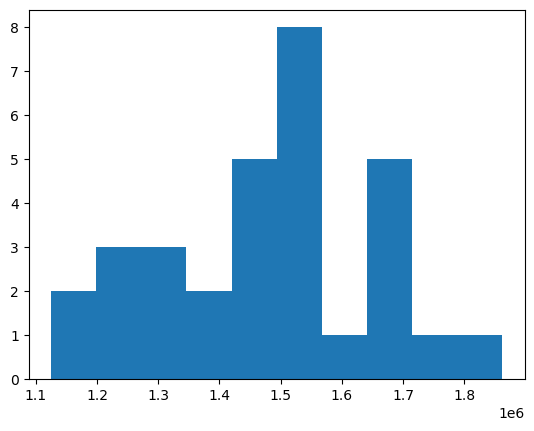

In [119]:
plt.hist(sums)

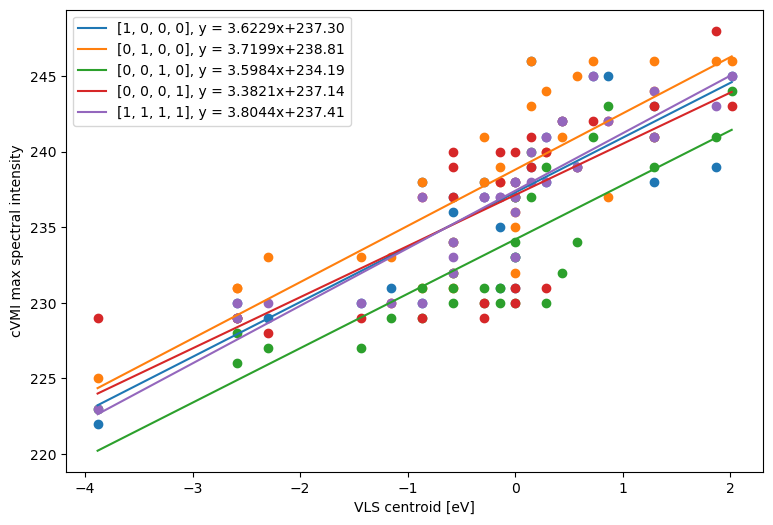

In [120]:
fig,axs = plt.subplots(figsize = (9,6))
#look_eVs = np.hstack((410, look_eVs))
#rrs = np.vstack((np.zeros(4),rrs))
#nns = np.hstack((0.1,nns))
for j, qfilter in enumerate(quadrant_filters):
    rplot = rrs[:,j]
    eVplot = nns #look_eVs #[ind]
    ind = np.argsort(eVplot)
    eVplot= eVplot[ind]
    rplot = rplot[ind]
    
    
    plt.scatter(eVplot, rplot) #, alpha = alphas)
    #plt.plot(rrs[:,j], look_eVs, alpha = 0.5,label = qfilter)
    #m,b,c = np.polyfit(eVplot, rplot, 2)
    m,b = np.polyfit(eVplot, rplot, 1)
    eV = np.linspace(eVplot[0],eVplot[-1], 40)
    #plt.plot(eV,m*eV**2+b*eV+c, label = str(qfilter) + ', y = %1.4fx^2+%1.2fx+%1.2f' %(m,b,c))
    plt.plot(eV,m*eV+b, label = str(qfilter) + ', y = %1.4fx+%1.2f' %(m,b))

plt.xlabel('VLS centroid [eV]')
plt.ylabel('cVMI max spectral intensity')
#plt.xlim(340,)
#plt.ylim(0,)
plt.legend()

In [8]:
def quadratic(x, a):
    return a*x**2


def quadratic_fit(r,eV):
    #spec = Et*Et.conj()
    popt, pcov = curve_fit(quadratic,r,eV, bounds=([0.00000000001], [10]))
    a = popt
    return a #FWHM is 2.355*sig


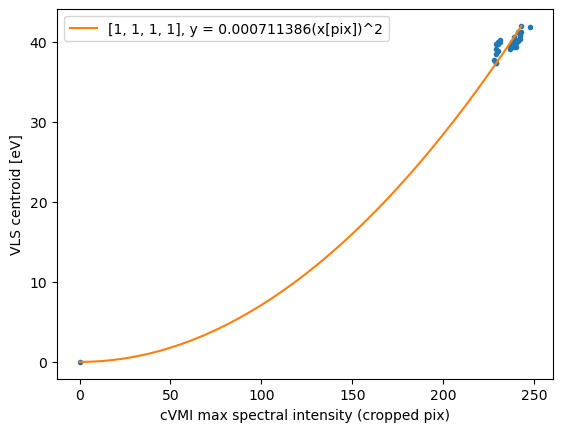

In [122]:
w0 = 40 #8#36 #this is energy_x in the vNbases gen code
j = -2
rplot = rrs[:,j]
eVplot = nns #look_eVs #[ind]
ind = np.argsort(eVplot)
eVplot= eVplot[ind]
rplot = rplot[ind]
#inds = (eVplot>-3.25) & (rplot<340) &  (rplot>310) & (sums> 1.3e6) & (maxes > 16)
inds = (eVplot>-3.25)
rplot = np.hstack(([0],rplot[inds]))
eVplot = np.hstack(([0],w0+eVplot[inds]))


#     rplot = rplot[eVplot>-3.25]
#     eVplot = eVplot[eVplot>-3.25]

#     eVplot = eVplot[rplot<350]
#     rplot = rplot[rplot<350]



plt.plot(rplot, eVplot,'.') #, alpha = alphas)
#plt.plot(rrs[:,j], look_eVs, alpha = 0.5,label = qfilter)
#m,b,c = np.polyfit(eVplot, rplot, 2)
a = quadratic_fit(rplot,eVplot)
rs = np.linspace(rplot[0],rplot[-1], 40)
plt.plot(rs,quadratic(rs, a), label = str(qfilter) + ', y = %1.9f(x[pix])^2' %(a))


plt.ylabel('VLS centroid [eV]')
plt.xlabel('cVMI max spectral intensity (cropped pix)')
#plt.xlim(340,)
#plt.ylim(0,)
plt.legend()

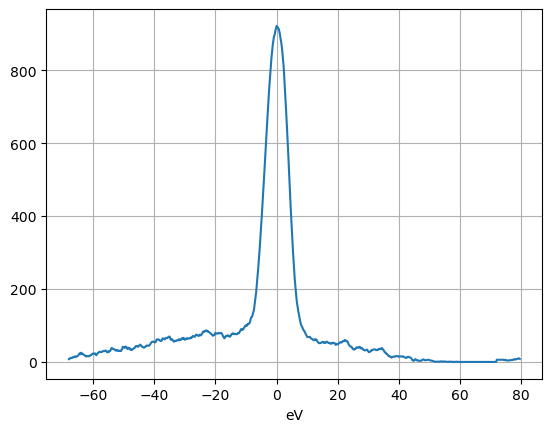

In [123]:
plt.plot(vls_eV - vls_eV[512], np.roll(np.mean(specs,axis = 0), offset) )
plt.xlabel('eV')
plt.grid()

In [31]:
p1 = Point(sss, pixpereV = pixpereV, w0 = 0, a1 = 0.1+0.2*np.random.rand()-0.2*np.random.rand(), a2 = 0.000, a3 = 0.000)
p1.make_Qs()
Q = p1.Qs
Ew = np.squeeze(np.matmul(Q.T,alphw))

NameError: name 'sss' is not defined

In [32]:
N = 2801
xf = np.arange(-N/2-1/2,N/2-1/2,1)/np.abs(vNaxis['t_sample'][0])/2
# xf = np.arange(-N/2+1/2,N/2+1/2,1)/((vNaxis['t_sample'][-1] - vNaxis['t_sample'][0])) #using tsample range
eV = 1239.84*(2*np.pi*xf)/2.9979E8/(2*np.pi)*1e-9 

In [33]:
N = 2801
xxf = np.arange(-N/2-1/2,N/2-1/2,1)/np.abs(vNaxis['t'][0])/2
# xf = np.arange(-N/2+1/2,N/2+1/2,1)/((vNaxis['t_sample'][-1] - vNaxis['t_sample'][0])) #using tsample range
xeV = 1239.84*(2*np.pi*xxf)/2.9979E8/(2*np.pi)*1e-9 

In [130]:
1239.84*vNaxis['w']/2.9979E8/(2*np.pi)*1e-9 

array([-48.85289703, -47.30201141, -45.75112579, -44.20024017,
       -42.64935455, -41.09846893, -39.54758331, -37.99669769,
       -36.44581207, -34.89492645, -33.34404083, -31.79315521,
       -30.24226959, -28.69138397, -27.14049835, -25.58961273,
       -24.03872711, -22.48784149, -20.93695587, -19.38607025,
       -17.83518463, -16.28429901, -14.73341339, -13.18252777,
       -11.63164215, -10.08075653,  -8.52987091,  -6.97898529,
        -5.42809967,  -3.87721405,  -2.32632843,  -0.77544281,
         0.77544281,   2.32632843,   3.87721405,   5.42809967,
         6.97898529,   8.52987091,  10.08075653,  11.63164215,
        13.18252777,  14.73341339,  16.28429901,  17.83518463,
        19.38607025,  20.93695587,  22.48784149,  24.03872711,
        25.58961273,  27.14049835,  28.69138397,  30.24226959,
        31.79315521,  33.34404083,  34.89492645,  36.44581207,
        37.99669769,  39.54758331,  41.09846893,  42.64935455,
        44.20024017,  45.75112579,  47.30201141,  48.85

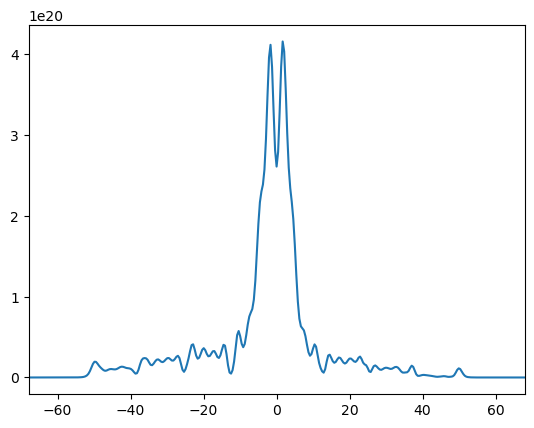

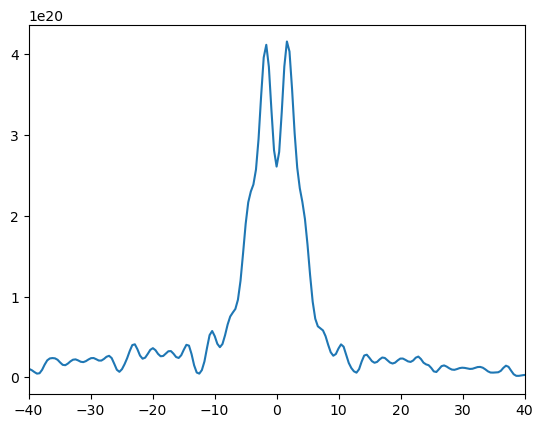

In [137]:
plt.plot(eV,Ew*Ew.conj())
plt.xlim((vls_eV - vls_eV[512])[0],-(vls_eV - vls_eV[512])[0])# (vls_eV - vls_eV[512])[-1])
plt.show()

plt.plot(eV,Ew*Ew.conj())
plt.xlim(-40,40)
plt.show()

In [64]:
pixpereV

6.95

In [161]:
gfsig = 1.985 #0.985 
Ups = [0.0]
Bps = []
alphas = []
vNaxiss = []
alphaws = []
N_w = 6
N_t = 6
Nb = N_w*N_t
for i in range(len(Ups)):
    Np = 128
    Up = Ups[i]  
    filename = 'Bpbasis_Up_' + str(Up)+'eV.npy'
    print(filename)
    BB = np.load(basesdir+filename, allow_pickle=True)
    
    Breal = np.real(BB)
    Bimag = np.imag(BB)
    alpha_t_sample=np.load('/reg/d/psdm/tmo/tmoc00118/results/siqili/basis_functions/alpha_t_sample.npy')
    vNaxis_t=np.load('/reg/d/psdm/tmo/tmoc00118/results/siqili/basis_functions/vNaxis_t.npy')
    vNaxis_t_sample=np.load('/reg/d/psdm/tmo/tmoc00118/results/siqili/basis_functions/vNaxis_t_sample.npy')
    vNaxis_w=np.load('/reg/d/psdm/tmo/tmoc00118/results/siqili/basis_functions/vNaxis_w.npy')
    
    br = np.array({'Breal':Breal, 'Bimag': Bimag, 'vNaxis': {'t':vNaxis_t, 't_sample':vNaxis_t_sample, 'w':vNaxis_w}, 'alpha': {'t_sample':alpha_t_sample}})
   
    
    Breal = br[()]['Breal']
    Bimag = br[()]['Bimag']
    #breal = br[()]['breal']
    #bimag = br[()]['bimag']
    vNaxis = br[()]['vNaxis']
    alpha = br[()]['alpha']

    
    if Breal.shape[0] == 128**2:
        tempr = np.zeros((Breal.shape[0], 64**2))
        tempi = np.zeros((Breal.shape[0], 64**2))
        for i in range(len(Breal)):
            tempr[i,:] = np.reshape(rebin(np.reshape(Breal[i,:], [128,128])), [64**2])
            tempi[i,:] = np.reshape(rebin(np.reshape(Bimag[i,:], [128,128])), [64**2])

        Breal = tempr
        Bimag = tempi

    alphw = np.zeros(alpha['t_sample'].shape, dtype = complex)
    for i in range(len(alphw)):
        f = interp1d(vNaxis['t_sample'], alpha['t_sample'][i], fill_value = 0, bounds_error = False)
        N = 2801 #1024
        ts = np.linspace(vNaxis['t_sample'][0],-vNaxis['t_sample'][0], N)
        alphw[i] = np.fft.ifftshift(np.fft.ifft(f(ts)))

    Np = 64
    for j in range(Breal.shape[0]):
        temp=np.reshape(Breal[j,:],[Np,Np])
        polimg = PR.cart2pol(temp,32,32)
        bb = np.zeros((64,64))
        bb[1:64,1:64]= PR.pol2cart(scimg.filters.gaussian_filter(polimg,[gfsig,0]))
        Breal[j,:]=np.reshape(bb,newshape=(1,Np**2))
        #temp=scimg.filters.gaussian_filter(temp,0.8889)
        #Bpr[j,:]=Variable(Tensor(np.reshape(temp,newshape=(1,Np**2))))
        temp=np.reshape(Bimag[j,:],[Np,Np])
        polimg = PR.cart2pol(temp,32,32)
        bb = np.zeros((64,64))
        bb[1:64,1:64]= PR.pol2cart(scimg.filters.gaussian_filter(polimg,[gfsig,0]))
        Bimag[j,:]=np.reshape(bb,newshape=(1,Np**2))
        #temp=scimg.filters.gaussian_filter(temp,0.8889)
        #Bpi[j,:]=Variable(Tensor(np.reshape(temp,newshape=(1,Np**2))))

    Bp_basis = Breal+1j*Bimag

Bpbasis_Up_0.0eV.npy


/tmp/ipykernel_30784/501750727.py:57: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  bb[1:64,1:64]= PR.pol2cart(scimg.filters.gaussian_filter(polimg,[gfsig,0]))
/tmp/ipykernel_30784/501750727.py:64: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  bb[1:64,1:64]= PR.pol2cart(scimg.filters.gaussian_filter(polimg,[gfsig,0]))


In [162]:
#pixpereV = 29.471
#pixpereV = 6.95
pixpereV = 6.95

In [163]:
n = 20

tocorim = []
tocoreV = []

sss = np.roll(np.mean(specs,axis = 0), offset) #DON"T FORGET TO ROLL BEFORE POINT CLASS

quadrant_filters=[[1,0,0,0], [0,1,0,0], [0,0,1,0], [0,0,0,1], [1,1,1,1]]
ees = np.linspace(-4,2,n) #370,420
rrs0 = np.zeros((n,len(quadrant_filters)))
r1=200
r2 = 300
x0 = 512
y0 = 512


for i in range(n):
    ee = ees[i]
    p1 = Point(sss, pixpereV = pixpereV, w0 = ee, a1 = 0.1+0.2*np.random.rand()-0.2*np.random.rand(), a2 = 0.000, a3 = 0.000)
    p1.make_Qs()
    Q = p1.Qs
    Msol1=np.real(np.matmul(np.matmul(Q,Q.conj().transpose()).transpose().flatten(),Bp_basis))

    #Msol1 =  make_bg_fixed(sss, ee, vNaxis0, alpha0, Bp_basis0, vls_pitch = 5.399977, order = 3)
    Msol1 = np.reshape(Msol1,[64,64])#, [int(np.sqrt(Msol1.shape[0])),int(np.sqrt(Msol1.shape[0]))]))
    ii = cv2.resize(np.rot90(Msol1), (1024,1024), interpolation = cv2.INTER_AREA)
    
    for j, qfilter in enumerate(quadrant_filters):
        
        folded = resizeFolded(foldQuadrant(ii, x0, y0, qfilter), 512)
        out = pbasex(folded, gData, make_images=True) #, weights = w) # the alpha is redundant here #weights

        ints = out['IE'].T #'IE' is the spectral intensity of the spectra, in KE. ints has shape (n_ims, n_KE_bins)
        betas = out['betas'][:,1].T # assymetry parameter, proj(L_2)/proj(L_0). same shape as ints
        spec_to_plot = ints[0] if len(ints.shape)==2 else ints
        
        centroid = get_centroidish(spec_to_plot[r1:r2])
        rrs0[i,j] = ke_calib(np.arange(r1,r2))[centroid]
    
        #rrs0[i,j] = ke_calib(np.arange(r1,r2))[np.argmax(spec_to_plot[r1:r2])]
    tocorim.append(ii)
    tocoreV.append(centroid)

         
    print(rrs0[i,:])

/tmp/ipykernel_30784/334603441.py:64: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  self.Qs = np.linalg.lstsq(np.matmul(alpha_t.conj(),alpha_t.T)*(vNaxis['t_sample'][1] - vNaxis['t_sample'][0]),np.matmul(alpha_t.conj(),np.reshape(x,(2801,1))*2*np.pi*(t[1]-t[0])))[0]


[235. 235. 235. 235. 235.]
[235. 235. 236. 235. 235.]
[236. 236. 236. 236. 236.]
[236. 237. 237. 236. 236.]
[237. 237. 237. 237. 237.]
[237. 238. 238. 237. 237.]
[238. 238. 238. 238. 238.]
[238. 238. 238. 238. 238.]
[239. 239. 239. 239. 239.]
[239. 240. 239. 239. 239.]
[239. 240. 240. 239. 239.]
[240. 241. 241. 240. 241.]
[241. 241. 241. 240. 241.]
[242. 242. 242. 242. 242.]
[242. 242. 242. 242. 242.]
[242. 243. 243. 242. 242.]
[243. 243. 243. 243. 243.]
[243. 243. 243. 243. 243.]
[243. 244. 244. 243. 244.]
[244. 244. 244. 244. 244.]


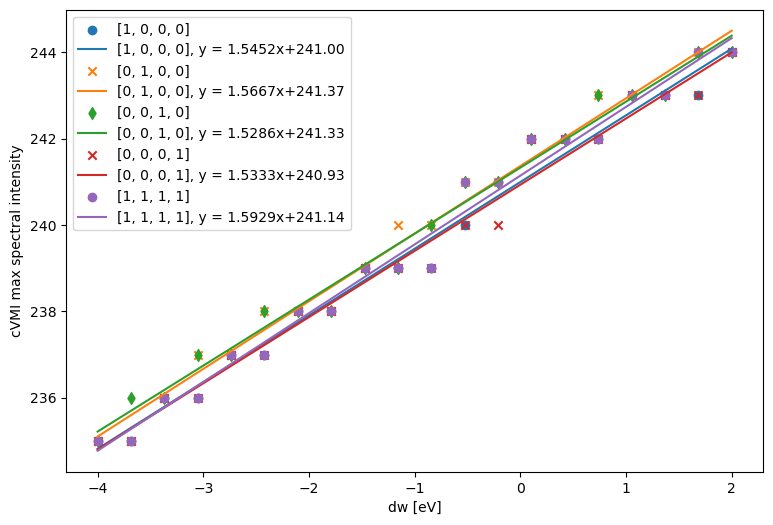

In [164]:
fig,axs = plt.subplots(figsize = (9,6))
plotstyle = ['o', 'x', 'd', 'x', 'o']
for j, qfilter in enumerate(quadrant_filters):
    plt.scatter(ees, rrs0[:,j], marker = plotstyle[j%5], label = qfilter)
    rplot = rrs0[:,j]
    eVplot = ees
    m,b = np.polyfit(eVplot,rplot, 1)
    eV = np.linspace(eVplot[0],eVplot[-1], 40)
    plt.plot(eV,m*eV+b, label = str(qfilter) + ', y = %1.4fx+%1.2f' %(m,b))
plt.xlabel('dw [eV]')

plt.ylabel('cVMI max spectral intensity')
plt.legend()

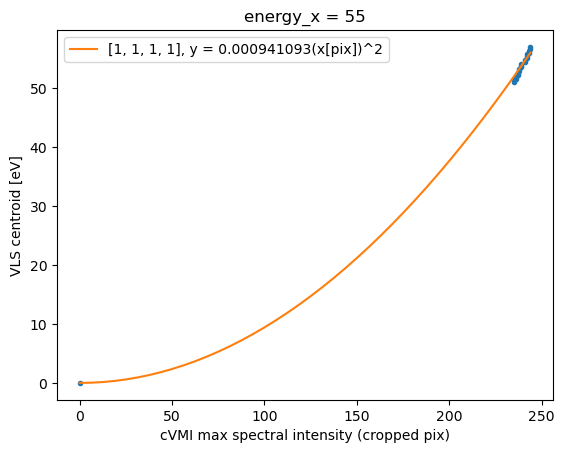

In [168]:
w0 = 55
j = -1
rplot = rrs0[:,j]
eVplot = ees #look_eVs #[ind]
ind = np.argsort(eVplot)
eVplot= eVplot[ind]
rplot = rplot[ind]
rplot = np.hstack(([0],rplot))
eVplot = np.hstack(([0],w0+eVplot))


#     rplot = rplot[eVplot>-3.25]
#     eVplot = eVplot[eVplot>-3.25]

#     eVplot = eVplot[rplot<350]
#     rplot = rplot[rplot<350]



plt.plot(rplot, eVplot,'.') #, alpha = alphas)
#plt.plot(rrs[:,j], look_eVs, alpha = 0.5,label = qfilter)
#m,b,c = np.polyfit(eVplot, rplot, 2)
a = quadratic_fit(rplot,eVplot)
rs = np.linspace(rplot[0],rplot[-1], 40)
plt.plot(rs,quadratic(rs, a), label = str(qfilter) + ', y = %1.9f(x[pix])^2' %(a))


plt.ylabel('VLS centroid [eV]')
plt.xlabel('cVMI max spectral intensity (cropped pix)')
plt.title('energy_x = %1.0f' %w0)
#plt.xlim(340,)
#plt.ylim(0,)
plt.legend()

In [155]:
w0 = 40

In [5]:
class Point():
    def __init__(self,spec, pixpereV, w0, a1, a2, a3):
        self.pixpereV = pixpereV
        self.spec = spec
        self.xeV = None #goes with spec
        self.w0 = w0
        self.a1 = a1
        self.a2 = a2
        self.a3 = a3
        self.Qs = None
        self.eV = None #goes with Ew
        self.tpreQ = None
        
    def make_Qs(self):
        '''
        spec - spectra profile with w0 at pix 512 ALREADY ROLLED
        w0 - where to shift center eV to
        a1,a2,a3 1st, 2nd, 3rd order chirps
        '''
        spec = self.spec
        spec[spec<0] = 0
        Ew0 = np.sqrt(spec)

        #make corresponding spectrum frequency axis in eV
        xeV = pix_2_eV(np.arange(len(Ew0)), pixpereV = self.pixpereV, spectra_hw0 = 0, spectra_pix0 = 512)
        #self.xeV = xeV
        xeV = xeV + self.w0

        # n1 = 2 #254 # spans range of vNaxis['w'] and centered around zero, in this case pix 512
        # n2 = -n1+1 
        # xeV = xeV[n1:n2] 
        # Ew0 = Ew0[n1:n2]
        
        n1 = 1# I do not know why this works
        xeV = xeV[n1:] 
        Ew0 = Ew0[n1:] 

        f = interpolate.interp1d(xeV, Ew0, fill_value = 'extrapolate')
        NN = 512*2 #how many points you want to use for the FFT, power of 2
        N = len(Ew0) #current length
        fx = interpolate.interp1d(np.arange(N), xeV, fill_value = 'extrapolate')
        xeV = fx(np.linspace(0, N-1, NN)) #make sure your points are evenly spaced for the FFT and you have the number of points you want
        Ew0 = f(xeV)

       # Ew_in = Ew0*np.exp(1j*(self.a1*(np.pi*2*(xeV-self.w0))+self.a2*(np.pi*2*(xeV-self.w0))**2+self.a3*(np.pi*2*(xeV-self.w0))**3)) #add in the phase
        Ew_in = Ew0*np.exp(1j*(self.a1*((xeV-self.w0))+self.a2*((xeV-self.w0))**2+self.a3*((xeV-self.w0))**3)) #add in the phase

        xf = 2.9979E8*xeV/1239.84e-9
        #f = np.abs(xf[-1])*2
        f = xf[-1] - xf[0]
        

        N = len(Ew_in) #this should be N = NN now
        #t = np.linspace(-N/f/2+1/f/2,N/f/2+1/f/2, N) 
        t = np.linspace(-N/f/2,N/f/2, N) 
        FFT = np.fft.fftshift(np.fft.fft(np.fft.fftshift(Ew_in))) #shift so central frequency is at 0
        car3 = np.exp(-1.j*(self.w0)/hbar*t)
        FFT = FFT*car3 #add in the frequency due to offset from zero frequency
        f = interpolate.interp1d(t, FFT, fill_value = 0, bounds_error = False) #fill_value = 'extrapolate')
        x = f(vNaxis['t_sample'])
        self.tpreQ = x*x.conj()
        alpha_t = alpha['t_sample']/np.max(np.abs(alpha['t_sample'])) #since we have shifted to right off zero frequency, do not add carrier to alpha

        self.Qs = np.linalg.lstsq(np.matmul(alpha_t.conj(),alpha_t.T)*(vNaxis['t_sample'][1] - vNaxis['t_sample'][0]),np.matmul(alpha_t.conj(),np.reshape(x,(2801,1))*2*np.pi*(t[1]-t[0])))[0]
        #*(vNaxis['t_sample'][1] - vNaxis['t_sample'][0]) is just a scalar, doesn't need to be evenly spaced?    
    
    def pix_2_eV(pixel, pixpereV = 22, spectra_hw0 = 0, spectra_pix0 = 512):
        '''
        pixel: array of pixel indices
        pixpereV: calibration pixels per eV
        spectral_hw: (optional) central energy if you have absolutes
        spectra_pix0: where to put w = 0, 512 is at the center for 1024pix spectrometer 
        '''
        spectra_dhwdpix = 1./pixpereV
        spectra_hws_eV = spectra_hw0 + spectra_dhwdpix*(pixel -spectra_pix0)
        return spectra_hws_eV

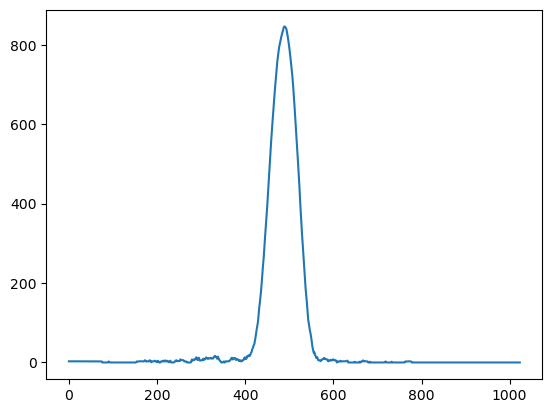

In [6]:
specdatname='/reg/d/psdm/tmo/tmoc00118/results/siqili/data/streaked_vls_processed_run_286.npy'
specdat = np.load(specdatname, allow_pickle = True)[()] 
sss= np.mean(specdat,axis = 0)
plt.plot(sss)


/tmp/ipykernel_16725/334603441.py:64: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  self.Qs = np.linalg.lstsq(np.matmul(alpha_t.conj(),alpha_t.T)*(vNaxis['t_sample'][1] - vNaxis['t_sample'][0]),np.matmul(alpha_t.conj(),np.reshape(x,(2801,1))*2*np.pi*(t[1]-t[0])))[0]


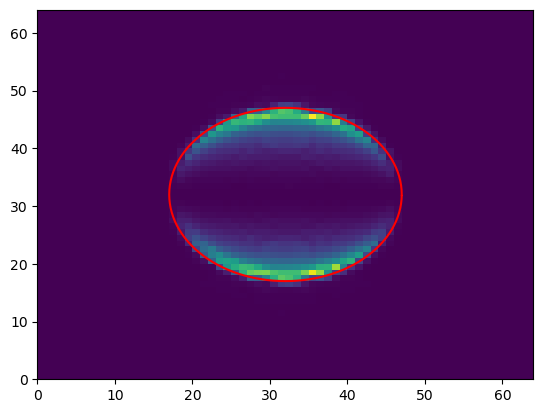

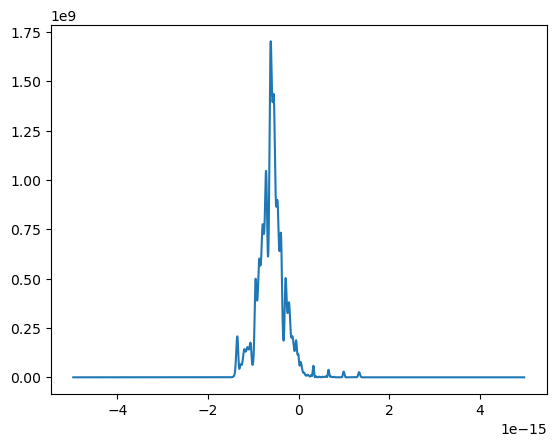

In [9]:
pixpereV = 22
p1 = Point(sss, pixpereV = pixpereV, w0 = 0, a1 = -1, a2 = 0.000, a3 = 0.000)
p1.make_Qs()
Q = p1.Qs
Msol1=np.real(np.matmul(np.matmul(Q,Q.conj().transpose()).transpose().flatten(),Bp_basis))

#Msol1 =  make_bg_fixed(sss, ee, vNaxis0, alpha0, Bp_basis0, vls_pitch = 5.399977, order = 3)
Msol1 = np.reshape(Msol1,[64,64])
plt.pcolormesh(Msol1)
r = 240 #360
binn = 32/2
phi_rad = np.arange(0,360)*np.pi/180
plt.plot((512+r*np.cos(phi_rad))/binn, (512+r*np.sin(phi_rad))/binn, c='r')
plt.show()
alpha_t = alpha['t_sample']/np.max(np.abs(alpha['t_sample'])) #since we have shifted to right off zero frequency, do not add carrier to alpha
Et = np.squeeze(np.matmul(Q.T,alpha_t))
plt.plot(vNaxis['t_sample'], np.real(Et*np.conj(Et)))


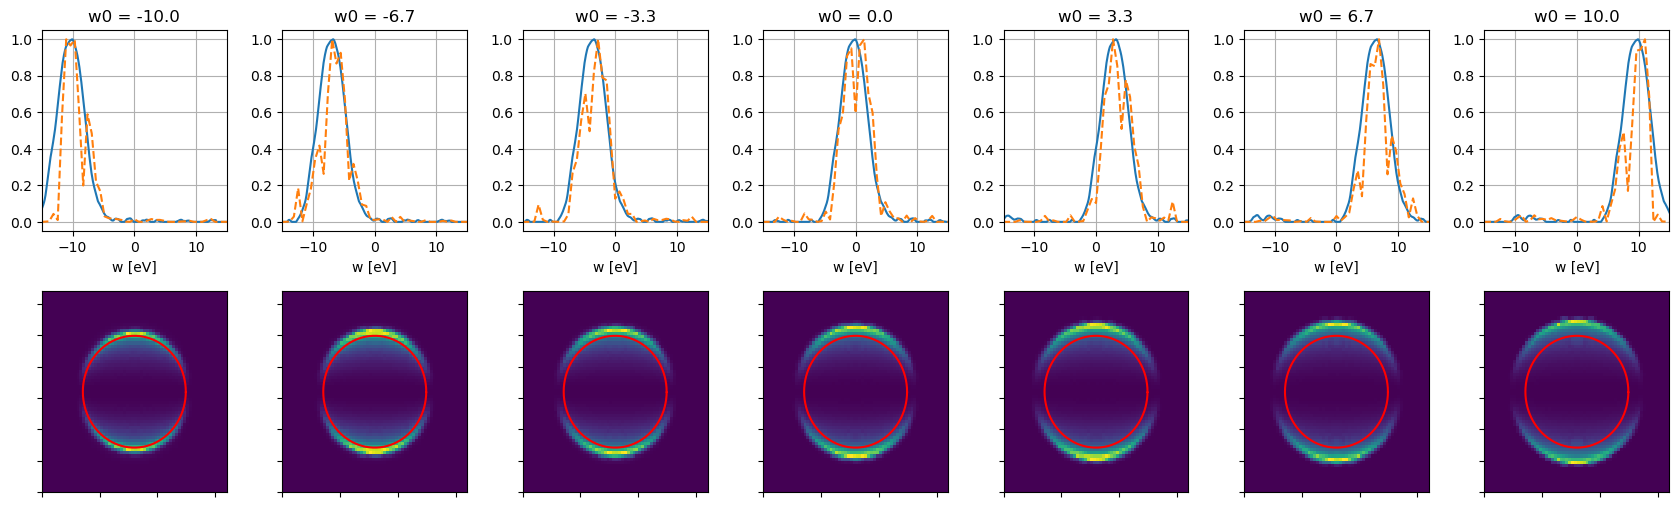

In [118]:
#check stuff
energy_x = 54
n = 7
ees = np.linspace(-10,10,n)

sss = fastsmooth1(specs[2],20)
sss[sss<0] = 0

fig,axs = plt.subplots(nrows = 2, ncols = n, figsize =(n*3, 2*3))
plt.subplots_adjust(hspace = 0.3, wspace = 0.3)

for i in range(n):
    ee = ees[i]
    spec = np.sqrt(sss)  #sqrt of intensity spectra to get E(w)
    pp =1200
    spec = np.pad(spec, (pp,), 'constant',constant_values=(0))
    N = len(spec)
    xeV = pix_2_eV(np.arange(N), pixpereV = 22, spectra_hw0 = 0, spectra_pix0 = pp+512)
    xeV = xeV + ee

    n1 = 0
    n2 = 3400 #want this to span 33.40369027550054 eV or less (range of vNaxis['w'])
                    #also need it to be centered around where you are calling zero or there will be an offset
    t1 = np.argmin((vNaxis['t_sample'] -vNaxis['t'][0])**2) #772
    t2 = np.argmin((vNaxis['t_sample'] -vNaxis['t'][-1])**2)#4828 [386:2414]
    xeV = xeV[n1:n2] 
    spec = spec[n1:n2] 
    spec = np.fft.fftshift(spec)


    axs[0][i].plot(xeV, np.real(np.fft.ifftshift(spec)**2/np.max(spec**2)), label = 'vls, Ew')

    f = interpolate.interp1d(xeV, spec, fill_value = 'extrapolate')
    NN = 512*2
    NNN = 0
    N = len(spec)
    fx = interpolate.interp1d(np.arange(N), xeV, fill_value = 'extrapolate')
    xeV = fx(np.linspace(0-NNN, N-1+NNN, NN))
    spec = f(xeV)
    xf = 2.9979E8*xeV/1239.84e-9

    f = xf[-1] - xf[0]
    N = len(spec)
    t = np.linspace(-N/f/2,N/f/2, N) 
    FFT = np.fft.fftshift(np.fft.fft(spec))


    car3 = np.exp(-1.j*(ee)/hbar*t)
    FFT = FFT*car3 #add in the frequency due to offset from zero frequency
    f = interpolate.interp1d(t, FFT, fill_value = 'extrapolate')
    x = f(vNaxis['t_sample'])
    alpha_t = alpha['t_sample']/np.max(np.abs(alpha['t_sample'])) #since we have shifted to right off zero frequency, do not add carrier to alpha

    Q = np.reshape(np.matmul(x, np.linalg.pinv(alpha_t)), [36,1])
    Msol1=np.real(np.matmul(np.matmul(Q,Q.conj().transpose()).transpose().flatten(),Bp_basis))


    Et = np.squeeze(np.matmul(Q.T,alpha_t))
    f = interpolate.interp1d(vNaxis['t_sample'], Et, fill_value = 'extrapolate') #take out offset you put in before solving Q
    ts = np.linspace(vNaxis['t_sample'][t1:t2][0],vNaxis['t_sample'][t1:t2][-1], N)
    st = np.fft.ifftshift(np.fft.ifft(f(ts)))
    specc = st*np.conj(st)
    specc = specc/np.max(np.abs(specc))

    xf = np.arange(-N/2,N/2,1)/(ts[-1] - ts[0])  #Hz???
    xxeV = 1239.84*(xf*2*np.pi)/2.9979E8/(2*np.pi)*1e-9

    axs[0][i].plot(xxeV, np.real(st*np.conj(st))/np.max(np.real(st*np.conj(st))), '--', label = 'Ew -> Et -> Q -> Et -> Ew')
    axs[0][i].set_xlim(-15,15)
    axs[0][i].set_title('w0 = %1.1f' %ee)
    axs[0][i].grid()
    axs[0][i].set_xlabel('w [eV]')
    axs[1][i].pcolormesh((np.reshape(Msol1, [64,64])))
    axs[1][i].set_xticklabels([])
    axs[1][i].set_yticklabels([])

    r = 285 #360
    binn = 32/2
    phi_rad = np.arange(0,360)*np.pi/180
    axs[1][i].plot((512+r*np.cos(phi_rad))/binn, (512+r*np.sin(phi_rad))/binn, c='r')

In [ ]:
#check stuff
energy_x = 54
n = 7
ees = np.linspace(-10,10,n)

sss = fastsmooth1(specs[2],20)
sss[sss<0] = 0

fig,axs = plt.subplots(nrows = 2, ncols = n, figsize =(n*3, 2*3))
plt.subplots_adjust(hspace = 0.3, wspace = 0.3)

for i in range(n):
    ee = ees[i]
    spec = np.sqrt(sss)  #sqrt of intensity spectra to get E(w)
    pp =1200
    spec = np.pad(spec, (pp,), 'constant',constant_values=(0))
    N = len(spec)
    xeV = pix_2_eV(np.arange(N), pixpereV = 22, spectra_hw0 = 0, spectra_pix0 = pp+512)
    xeV = xeV + ee

    n1 = 0
    n2 = 3400 #want this to span 33.40369027550054 eV or less (range of vNaxis['w'])
                    #also need it to be centered around where you are calling zero or there will be an offset
    t1 = np.argmin((vNaxis['t_sample'] -vNaxis['t'][0])**2) #772
    t2 = np.argmin((vNaxis['t_sample'] -vNaxis['t'][-1])**2)#4828 [386:2414]
    xeV = xeV[n1:n2] 
    spec = spec[n1:n2] 
    spec = np.fft.fftshift(spec)


    axs[0][i].plot(xeV, np.real(np.fft.ifftshift(spec)**2/np.max(spec**2)), label = 'vls, Ew')

    f = interpolate.interp1d(xeV, spec, fill_value = 'extrapolate')
    NN = 512*2
    NNN = 0
    N = len(spec)
    fx = interpolate.interp1d(np.arange(N), xeV, fill_value = 'extrapolate')
    xeV = fx(np.linspace(0-NNN, N-1+NNN, NN))
    spec = f(xeV)
    xf = 2.9979E8*xeV/1239.84e-9

    f = xf[-1] - xf[0]
    N = len(spec)
    t = np.linspace(-N/f/2,N/f/2, N) 
    FFT = np.fft.fftshift(np.fft.fft(spec))


    car3 = np.exp(-1.j*(ee)/hbar*t)
    FFT = FFT*car3 #add in the frequency due to offset from zero frequency
    f = interpolate.interp1d(t, FFT, fill_value = 'extrapolate')
    x = f(vNaxis['t_sample'])
    alpha_t = alpha['t_sample']/np.max(np.abs(alpha['t_sample'])) #since we have shifted to right off zero frequency, do not add carrier to alpha

    Q = np.reshape(np.matmul(x, np.linalg.pinv(alpha_t)), [36,1])
    Msol1=np.real(np.matmul(np.matmul(Q,Q.conj().transpose()).transpose().flatten(),Bp_basis))


    Et = np.squeeze(np.matmul(Q.T,alpha_t))
    f = interpolate.interp1d(vNaxis['t_sample'], Et, fill_value = 'extrapolate') #take out offset you put in before solving Q
    ts = np.linspace(vNaxis['t_sample'][t1:t2][0],vNaxis['t_sample'][t1:t2][-1], N)
    st = np.fft.ifftshift(np.fft.ifft(f(ts)))
    specc = st*np.conj(st)
    specc = specc/np.max(np.abs(specc))

    xf = np.arange(-N/2,N/2,1)/(ts[-1] - ts[0])  #Hz???
    xxeV = 1239.84*(xf*2*np.pi)/2.9979E8/(2*np.pi)*1e-9

    axs[0][i].plot(xxeV, np.real(st*np.conj(st))/np.max(np.real(st*np.conj(st))), '--', label = 'Ew -> Et -> Q -> Et -> Ew')
    axs[0][i].set_xlim(-15,15)
    axs[0][i].set_title('w0 = %1.1f' %ee)
    axs[0][i].grid()
    axs[0][i].set_xlabel('w [eV]')
    axs[1][i].pcolormesh((np.reshape(Msol1, [64,64])))
    axs[1][i].set_xticklabels([])
    axs[1][i].set_yticklabels([])

    r = 285 #360
    binn = 32/2
    phi_rad = np.arange(0,360)*np.pi/180
    axs[1][i].plot((512+r*np.cos(phi_rad))/binn, (512+r*np.sin(phi_rad))/binn, c='r')

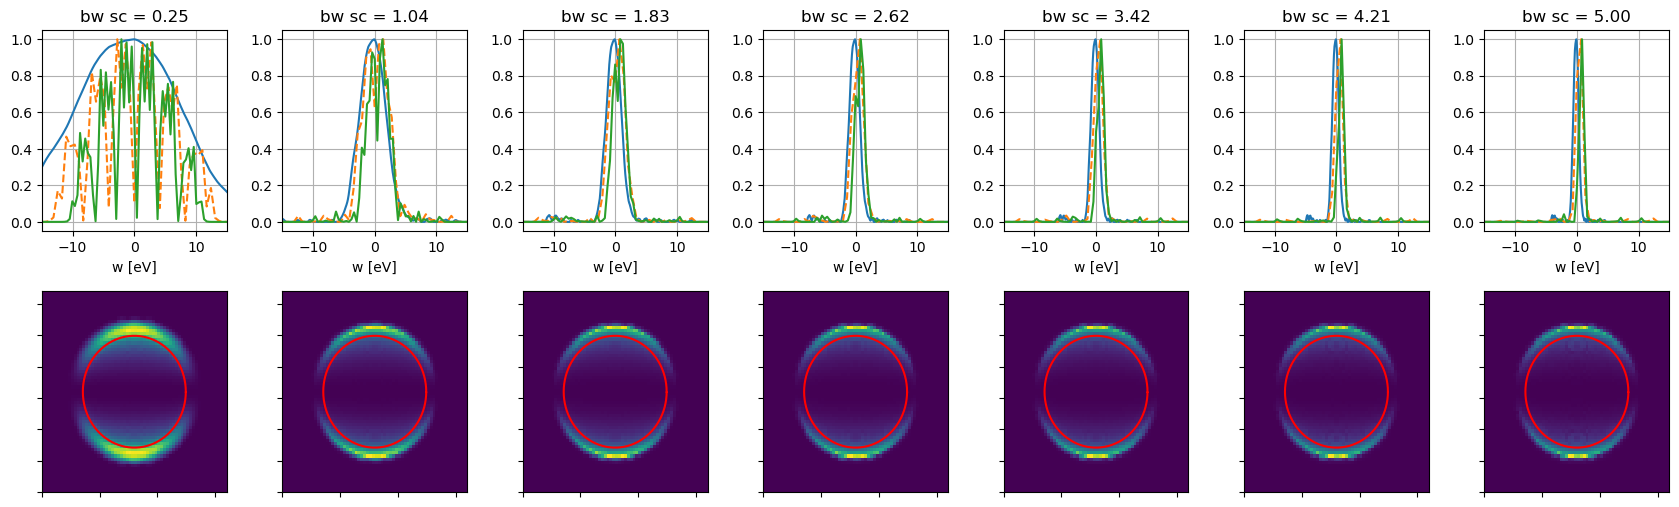

In [10]:
#check stuff
energy_x = 54
n = 7
scales = np.linspace(0.25, 5, n)
ee = 0
sss = fastsmooth1(specs[2],20)
sss[sss<0] = 0

check_ims = []

N = 2801
xf = np.arange(-N/2,N/2,1)/((vNaxis['t_sample'][-1] - vNaxis['t_sample'][0])) #using tsample range
eV = 1239.84*(2*np.pi*xf)/2.9979E8/(2*np.pi)*1e-9 

fig,axs = plt.subplots(nrows = 2, ncols = n, figsize =(n*3, 2*3))
plt.subplots_adjust(hspace = 0.3, wspace = 0.3)

for i in range(n):
    ee = 0
    spec = np.sqrt(sss)  #sqrt of intensity spectra to get E(w)
    
    x1 = np.arange(len(sss))
    f = interpolate.interp1d(x1, spec, fill_value = 0, bounds_error = False)
    sc = scales[i] #3.5/5
    xs = np.linspace(sc*(x1[0] -np.argmax(spec)), sc*(x1[-1]-np.argmax(spec)), len(x1))+np.argmax(spec)
    spec = f(xs)
    
    pp =1200
    spec = np.pad(spec, (pp,), 'constant',constant_values=(0))
    N = len(spec)
    xeV = pix_2_eV(np.arange(N), pixpereV = 22, spectra_hw0 = 0, spectra_pix0 = pp+512)
    xeV = xeV + ee

    n1 = 0
    n2 = 3400 #want this to span 33.40369027550054 eV or less (range of vNaxis['w'])
                    #also need it to be centered around where you are calling zero or there will be an offset
    t1 = np.argmin((vNaxis['t_sample'] -vNaxis['t'][0])**2) #772
    t2 = np.argmin((vNaxis['t_sample'] -vNaxis['t'][-1])**2)#4828 [386:2414]
    xeV = xeV[n1:n2] 
    spec = spec[n1:n2] 
    xeV1 = np.copy(xeV)
    spec1 = np.copy(spec)
    spec = np.fft.fftshift(spec)


    axs[0][i].plot(xeV, np.real(np.fft.ifftshift(spec)**2/np.max(spec**2)), label = 'vls, Ew')

    f = interpolate.interp1d(xeV, spec, fill_value = 'extrapolate')
    NN = 512*2
    NNN = 0
    N = len(spec)
    fx = interpolate.interp1d(np.arange(N), xeV, fill_value = 'extrapolate')
    xeV = fx(np.linspace(0-NNN, N-1+NNN, NN))
    spec = f(xeV)
    xf = 2.9979E8*xeV/1239.84e-9

    f = xf[-1] - xf[0]
    N = len(spec)
    t = np.linspace(-N/f/2,N/f/2, N) 
    FFT = np.fft.fftshift(np.fft.fft(spec))


    car3 = np.exp(-1.j*(ee)/hbar*t)
    FFT = FFT*car3 #add in the frequency due to offset from zero frequency
    f = interpolate.interp1d(t, FFT, fill_value = 'extrapolate')
    x = f(vNaxis['t_sample'])
    alpha_t = alpha['t_sample']/np.max(np.abs(alpha['t_sample'])) #since we have shifted to right off zero frequency, do not add carrier to alpha

    Q = np.reshape(np.matmul(x, np.linalg.pinv(alpha_t)), [36,1])
    Msol1=np.real(np.matmul(np.matmul(Q,Q.conj().transpose()).transpose().flatten(),Bp_basis))
    

    Et = np.squeeze(np.matmul(Q.T,alpha_t))
    f = interpolate.interp1d(vNaxis['t_sample'], Et, fill_value = 'extrapolate') #take out offset you put in before solving Q
    ts = np.linspace(vNaxis['t_sample'][t1:t2][0],vNaxis['t_sample'][t1:t2][-1], N)
    st = np.fft.ifftshift(np.fft.ifft(f(ts)))
    specc = st*np.conj(st)
    specc = specc/np.max(np.abs(specc))

    xf = np.arange(-N/2,N/2,1)/(ts[-1] - ts[0])  #Hz???
    xxeV = 1239.84*(xf*2*np.pi)/2.9979E8/(2*np.pi)*1e-9

    axs[0][i].plot(xxeV, np.real(st*np.conj(st))/np.max(np.real(st*np.conj(st))), '--', label = 'Ew -> Et -> Q -> Et -> Ew')
    axs[0][i].set_xlim(-15,15)
    axs[0][i].set_title('bw sc = %1.2f' %sc)
    axs[0][i].grid()
    axs[0][i].set_xlabel('w [eV]')
    axs[1][i].pcolormesh((np.reshape(Msol1, [64,64])))
    check_ims.append(np.reshape(Msol1, [64,64]))
    axs[1][i].set_xticklabels([])
    axs[1][i].set_yticklabels([])
    
    Ew = np.squeeze(np.matmul(Q.T,alphw))
    EwEw = np.real(Ew*Ew.conj())
    EwEw = EwEw[1340:-1340]
    EwEw = EwEw/np.max(EwEw)
    axs[0][i].plot(np.linspace(eV[1340],eV[-1340], len(EwEw)), np.squeeze(EwEw), 'tab:green')
    
#     spec_in = spec1
#     f = interpolate.interp1d(xeV1, spec_in, fill_value = 0, bounds_error= False) #take out offset you put in before solving Q
#     Q = np.reshape(np.matmul(np.reshape(f(eV),[1,2801]), np.linalg.pinv(alphw)), [36,1])
#     Ew = np.squeeze(np.matmul(Q.T,alphw))
#     EwEw = np.real(Ew*Ew.conj())
#     EwEw = EwEw[1340:-1340]
#     EwEw = EwEw/np.max(EwEw)
#     axs[0][i].plot(np.linspace(eV[1340],eV[-1340], len(EwEw)), np.squeeze(EwEw), 'r')
    

    r = 285 #360
    binn = 32/2
    phi_rad = np.arange(0,360)*np.pi/180
    axs[1][i].plot((512+r*np.cos(phi_rad))/binn, (512+r*np.sin(phi_rad))/binn, c='r')

(-10.0, 10.0)

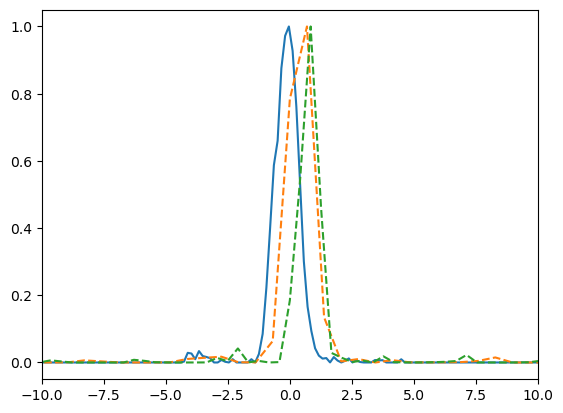

In [19]:
plt.plot(xeV, np.real(np.fft.ifftshift(spec)**2/np.max(spec**2)), label = 'vls, Ew')
plt.plot(xxeV, np.real(st*np.conj(st))/np.max(np.real(st*np.conj(st))), '--', label = 'Ew -> Et -> Q -> Et -> Ew')
Ew = np.squeeze(np.matmul(Q.T,alphw))
EwEw2 = np.real(Ew)**2+np.imag(Ew)**2
EwEw2 = EwEw2[1340:-1340]
EwEw2 = EwEw2/np.max(EwEw2)
plt.plot(np.linspace(eV[1340],eV[-1340], len(EwEw2)), np.squeeze(EwEw2), '--')
plt.xlim(-10,10)

In [144]:
64**2

4096

In [146]:
36**2

1296

In [150]:
np.matmul(Q,Q.conj().transpose()).transpose().shape

(36, 36)

In [149]:
np.matmul(Q,Q.conj().transpose()).transpose().flatten().shape

(1296,)

In [145]:
Q.shape

(36, 1)

In [143]:
Bp_basis.shape

(1296, 4096)

In [115]:
Q0 = np.zeros((36,1), complex)
Q0[20] = 1 + 1j
Q0[3] = 1 

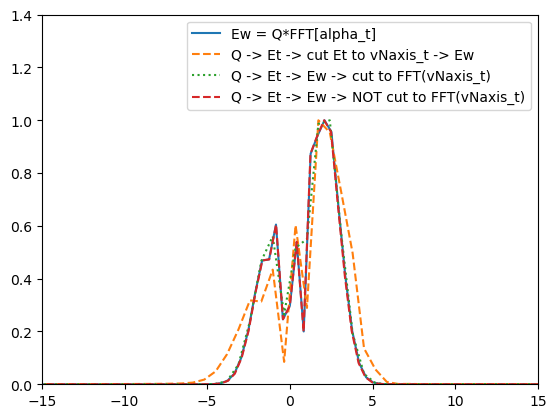

In [116]:
Ew = np.squeeze(np.matmul(Q0.T,alphw))
EwEw2 = np.real(Ew)**2+np.imag(Ew)**2
EwEw2 = EwEw2[1340:-1340]
EwEw2 = EwEw2/np.max(EwEw2)
eV0 = np.linspace(eV[1340],eV[-1340], len(EwEw2))
plt.plot(eV0, np.squeeze(EwEw2), '-', label = 'Ew = Q*FFT[alpha_t]')


Et = np.squeeze(np.matmul(Q0.T,alpha_t))
f = interpolate.interp1d(vNaxis['t_sample'], Et, fill_value = 'extrapolate') #take out offset you put in before solving Q
ts = np.linspace(vNaxis['t_sample'][t1:t2][0],vNaxis['t_sample'][t1:t2][-1], N)
st = np.fft.ifftshift(np.fft.ifft(f(ts)))
specc = st*np.conj(st)
specc = specc/np.max(np.abs(specc))

xf = np.arange(-N/2+1/2,N/2+1/2,1)/(ts[-1] - ts[0])  #Hz???
xxeV = 1239.84*(xf*2*np.pi)/2.9979E8/(2*np.pi)*1e-9

plt.plot(xxeV, np.real(st*np.conj(st))/np.max(np.real(st*np.conj(st))), '--', label = 'Q -> Et -> cut Et to vNaxis_t -> Ew')


Et = np.squeeze(np.matmul(Q0.T,alpha_t))
NN = len(Et) #2801
ts = np.linspace(vNaxis['t_sample'][0],vNaxis['t_sample'][-1], NN)
st = np.fft.ifftshift(np.fft.ifft(Et))
specc = st*np.conj(st)
specc = specc/np.max(np.abs(specc))

xxf = np.arange(-NN/2+1/2,NN/2+1/2,1)/(ts[-1] - ts[0])  #Hz???
xxxeV = 1239.84*(xxf*2*np.pi)/2.9979E8/(2*np.pi)*1e-9
f = interpolate.interp1d(xxxeV, specc, fill_value = 'extrapolate') #take out offset you put in before solving Q
speccc = np.real(f(xxeV))
#speccc = np.real(f(eV0))
plt.plot(xxeV,speccc/np.max(speccc) , ':', label = 'Q -> Et -> Ew -> cut to FFT(vNaxis_t)')
plt.plot(xxxeV,specc, '--', label = 'Q -> Et -> Ew -> NOT cut to FFT(vNaxis_t)')
plt.xlim(-15,15)
plt.ylim(0,1.4)
plt.legend()

In [88]:
np.linspace(eV[1340],eV[-1340], len(EwEw2))

array([-25.14668811, -24.72757664, -24.30846517, -23.8893537 ,
       -23.47024223, -23.05113077, -22.6320193 , -22.21290783,
       -21.79379636, -21.37468489, -20.95557342, -20.53646196,
       -20.11735049, -19.69823902, -19.27912755, -18.86001608,
       -18.44090461, -18.02179314, -17.60268168, -17.18357021,
       -16.76445874, -16.34534727, -15.9262358 , -15.50712433,
       -15.08801287, -14.6689014 , -14.24978993, -13.83067846,
       -13.41156699, -12.99245552, -12.57334405, -12.15423259,
       -11.73512112, -11.31600965, -10.89689818, -10.47778671,
       -10.05867524,  -9.63956378,  -9.22045231,  -8.80134084,
        -8.38222937,  -7.9631179 ,  -7.54400643,  -7.12489496,
        -6.7057835 ,  -6.28667203,  -5.86756056,  -5.44844909,
        -5.02933762,  -4.61022615,  -4.19111468,  -3.77200322,
        -3.35289175,  -2.93378028,  -2.51466881,  -2.09555734,
        -1.67644587,  -1.25733441,  -0.83822294,  -0.41911147,
         0.        ,   0.41911147,   0.83822294,   1.25

In [137]:
xxf = np.arange(-NN/2+1/2,NN/2+1/2,1)/(ts[-1] - ts[0])  #Hz???
xxxeV = 1239.84*(xxf*2*np.pi)/2.9979E8/(2*np.pi)*1e-9

array([-5.85833333e-17, -5.55000000e-17, -5.24166667e-17, -4.93333333e-17,
       -4.62500000e-17, -4.31666667e-17, -4.00833333e-17, -3.70000000e-17,
       -3.39166667e-17, -3.08333333e-17, -2.77500000e-17, -2.50000000e-17,
       -2.46666667e-17, -2.15833333e-17, -1.85000000e-17, -1.54166667e-17,
       -1.23333333e-17, -9.25000000e-18, -6.16666667e-18, -3.08333333e-18,
        2.99767144e-28,  3.08333333e-18,  6.16666667e-18,  9.25000000e-18,
        1.23333333e-17,  1.54166667e-17,  1.85000000e-17,  2.15833333e-17,
        2.46666667e-17,  2.50000000e-17])

array([-1.65507190e-39-4.83892148e-40j, -8.68128749e-39-1.14916281e-39j,
       -4.38054934e-38+9.29997904e-40j, ...,
        8.55812435e-08+1.05990366e-07j,  6.75639487e-08+8.65190210e-09j,
        2.69788500e-08-1.99534534e-08j])

In [50]:
f(ts)

array([-1.47090773e-16-8.45126381e-17j, -1.67926347e-16-9.25141989e-17j,
       -1.91584909e-16-1.01110726e-16j, ...,
       -1.51410760e-02-6.02186481e-01j, -6.79356090e-02-5.89864278e-01j,
       -1.18664404e-01-5.73008708e-01j])

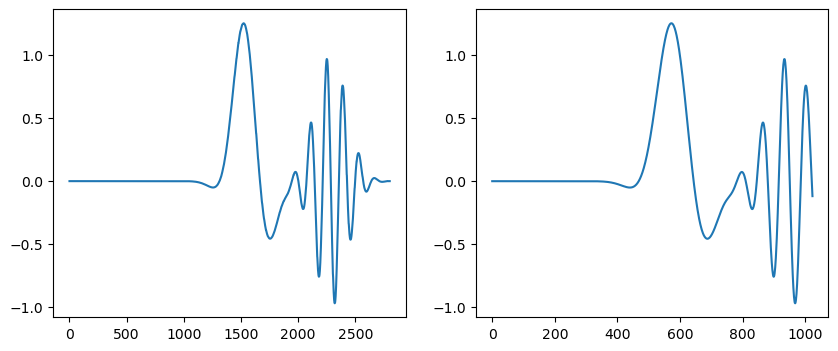

In [54]:
fig,axs = plt.subplots(nrows=1,ncols =2,figsize=(10,4))
axs[0].plot(Et)
axs[1].plot(f(ts))

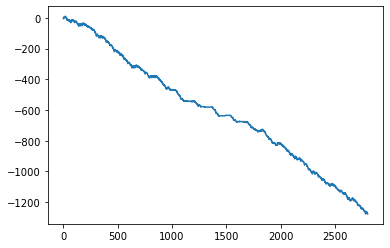

In [61]:
plt.plot(np.unwrap(np.angle(Ew)))

(-14.0, 14.0)

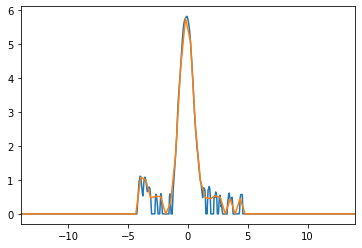

In [37]:
plt.plot(xeV1, spec1)
plt.plot(eV, f(eV))
plt.xlim(-14,14)

In [57]:
zz = spec1*np.exp(1j*np.linspace(0,np.pi, len(spec1)))

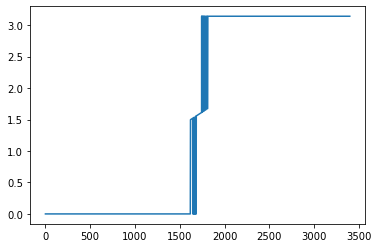

In [58]:
plt.plot(np.unwrap(np.angle(zz)))

In [40]:
np.reshape(f(eV),[1,2801]).shape

(1, 2801)

In [39]:
np.linalg.pinv(alphw).shape

(2801, 36)

In [41]:
Q = np.reshape(np.matmul(np.reshape(f(eV),[1,2801]), np.linalg.pinv(alphw)), [36,1])

In [22]:
alphw.shape

(36, 2801)

In [25]:
alpha_t.shape

(36, 2801)

In [27]:
vNaxis['t_sample'].shape

(2801,)

In [28]:
eV.shape

(2801,)

In [29]:
spec.shape

(1024,)

In [128]:
for i in range(len(check_ims)):
    print(np.sum(check_ims[i]))

455940999681.4675
156637283705.36133
93187095650.82281
66201254009.714806
51075478568.74972
40852444335.085335
34865772144.415146


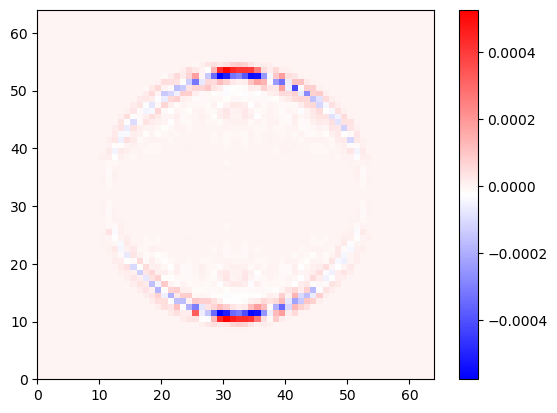

In [136]:
a = 1
b = 2
plt.pcolormesh(check_ims[a]/np.sum(check_ims[a]) - check_ims[b]/np.sum(check_ims[b]), cmap = 'bwr')
plt.colorbar()

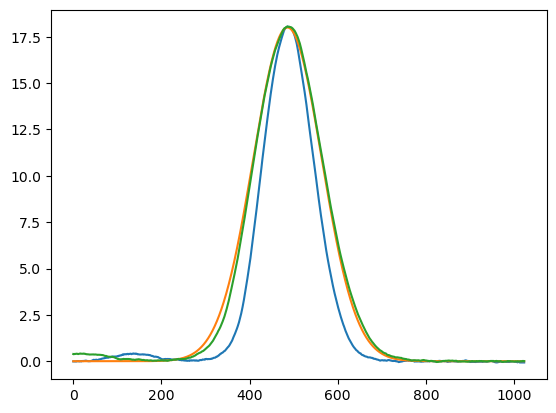

In [279]:
sss = np.mean(specs, axis = 0) #ss[0:20,:]
plt.plot(sss)
x = np.arange(len(sss))
#um = 22*np.exp(-((x-np.argmax(sss))/10)**2)
um = 18*np.exp(-((x-np.argmax(sss))/110)**2)
#um = 22*np.exp(-((x-np.argmax(sss))/100)**2)
plt.plot(um)
x1 = np.arange(len(sss))
f = interpolate.interp1d(x1, sss, fill_value = 0, bounds_error = False)
sc = 3.5/4.7
xs = np.linspace(sc*(x1[0] -np.argmax(sss)), sc*(x1[-1]-np.argmax(sss)), len(x1))+np.argmax(sss)
plt.plot(f(xs))

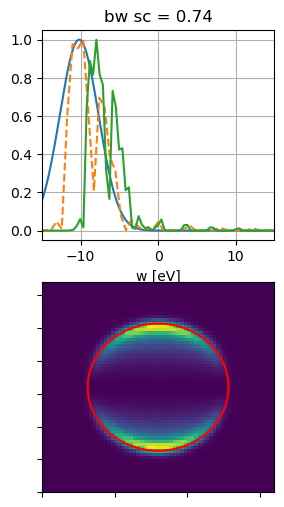

In [92]:
spec = um
ee = -9
    
fig,axs = plt.subplots(nrows = 2, ncols = 1, figsize =(3, 2*3))
N = 2801
xf = np.arange(-N/2,N/2,1)/((vNaxis['t_sample'][-1] - vNaxis['t_sample'][0])) #using tsample range
eV = 1239.84*(2*np.pi*xf)/2.9979E8/(2*np.pi)*1e-9 
pp =1200
spec = np.pad(spec, (pp,), 'constant',constant_values=(0))
N = len(spec)
xeV = pix_2_eV(np.arange(N), pixpereV = 22, spectra_hw0 = 0, spectra_pix0 = pp+512)
xeV = xeV + ee

n1 = 0
n2 = 3400 #want this to span 33.40369027550054 eV or less (range of vNaxis['w'])
                #also need it to be centered around where you are calling zero or there will be an offset
t1 = np.argmin((vNaxis['t_sample'] -vNaxis['t'][0])**2) #772
t2 = np.argmin((vNaxis['t_sample'] -vNaxis['t'][-1])**2)#4828 [386:2414]
xeV = xeV[n1:n2] 
spec = spec[n1:n2] 
xeV1 = np.copy(xeV)
spec1 = np.copy(spec)
spec = np.fft.fftshift(spec)


axs[0].plot(xeV, np.real(np.fft.ifftshift(spec)**2/np.max(spec**2)), label = 'vls, Ew')

f = interpolate.interp1d(xeV, spec, fill_value = 'extrapolate')
NN = 512*2
NNN = 0
N = len(spec)
fx = interpolate.interp1d(np.arange(N), xeV, fill_value = 'extrapolate')
xeV = fx(np.linspace(0-NNN, N-1+NNN, NN))
spec = f(xeV)
xf = 2.9979E8*xeV/1239.84e-9

f = xf[-1] - xf[0]
N = len(spec)
t = np.linspace(-N/f/2,N/f/2, N) 
FFT = np.fft.fftshift(np.fft.fft(spec))


car3 = np.exp(-1.j*(ee)/hbar*t)
FFT = FFT*car3 #add in the frequency due to offset from zero frequency
f = interpolate.interp1d(t, FFT, fill_value = 'extrapolate')
x = f(vNaxis['t_sample'])
alpha_t = alpha['t_sample']/np.max(np.abs(alpha['t_sample'])) #since we have shifted to right off zero frequency, do not add carrier to alpha

Q = np.reshape(np.matmul(x, np.linalg.pinv(alpha_t)), [36,1])
Msol1=np.real(np.matmul(np.matmul(Q,Q.conj().transpose()).transpose().flatten(),Bp_basis))


Et = np.squeeze(np.matmul(Q.T,alpha_t))
f = interpolate.interp1d(vNaxis['t_sample'], Et, fill_value = 'extrapolate') #take out offset you put in before solving Q
ts = np.linspace(vNaxis['t_sample'][t1:t2][0],vNaxis['t_sample'][t1:t2][-1], N)
st = np.fft.ifftshift(np.fft.ifft(f(ts)))
specc = st*np.conj(st)
specc = specc/np.max(np.abs(specc))

xf = np.arange(-N/2,N/2,1)/(ts[-1] - ts[0])  #Hz???
xxeV = 1239.84*(xf*2*np.pi)/2.9979E8/(2*np.pi)*1e-9

axs[0].plot(xxeV, np.real(st*np.conj(st))/np.max(np.real(st*np.conj(st))), '--', label = 'Ew -> Et -> Q -> Et -> Ew')
axs[0].set_xlim(-15,15)
axs[0].set_title('bw sc = %1.2f' %sc)
axs[0].grid()
axs[0].set_xlabel('w [eV]')
axs[1].pcolormesh((np.reshape(Msol1, [64,64])))
axs[1].set_xticklabels([])
axs[1].set_yticklabels([])

Ew = np.squeeze(np.matmul(Q.T,alphw))
EwEw = np.real(Ew*Ew.conj())
EwEw = EwEw[1340:-1340]
EwEw = EwEw/np.max(EwEw)
axs[0].plot(np.linspace(eV[1340],eV[-1340], len(EwEw)), np.squeeze(EwEw), 'tab:green')

#     spec_in = spec1
#     f = interpolate.interp1d(xeV1, spec_in, fill_value = 0, bounds_error= False) #take out offset you put in before solving Q
#     Q = np.reshape(np.matmul(np.reshape(f(eV),[1,2801]), np.linalg.pinv(alphw)), [36,1])
#     Ew = np.squeeze(np.matmul(Q.T,alphw))
#     EwEw = np.real(Ew*Ew.conj())
#     EwEw = EwEw[1340:-1340]
#     EwEw = EwEw/np.max(EwEw)
#     axs[0][i].plot(np.linspace(eV[1340],eV[-1340], len(EwEw)), np.squeeze(EwEw), 'r')


r = 310 #looks like centroid of points is around 310 pix #360
binn = 32/2
phi_rad = np.arange(0,360)*np.pi/180
axs[1].plot((512+r*np.cos(phi_rad))/binn, (512+r*np.sin(phi_rad))/binn, c='r')

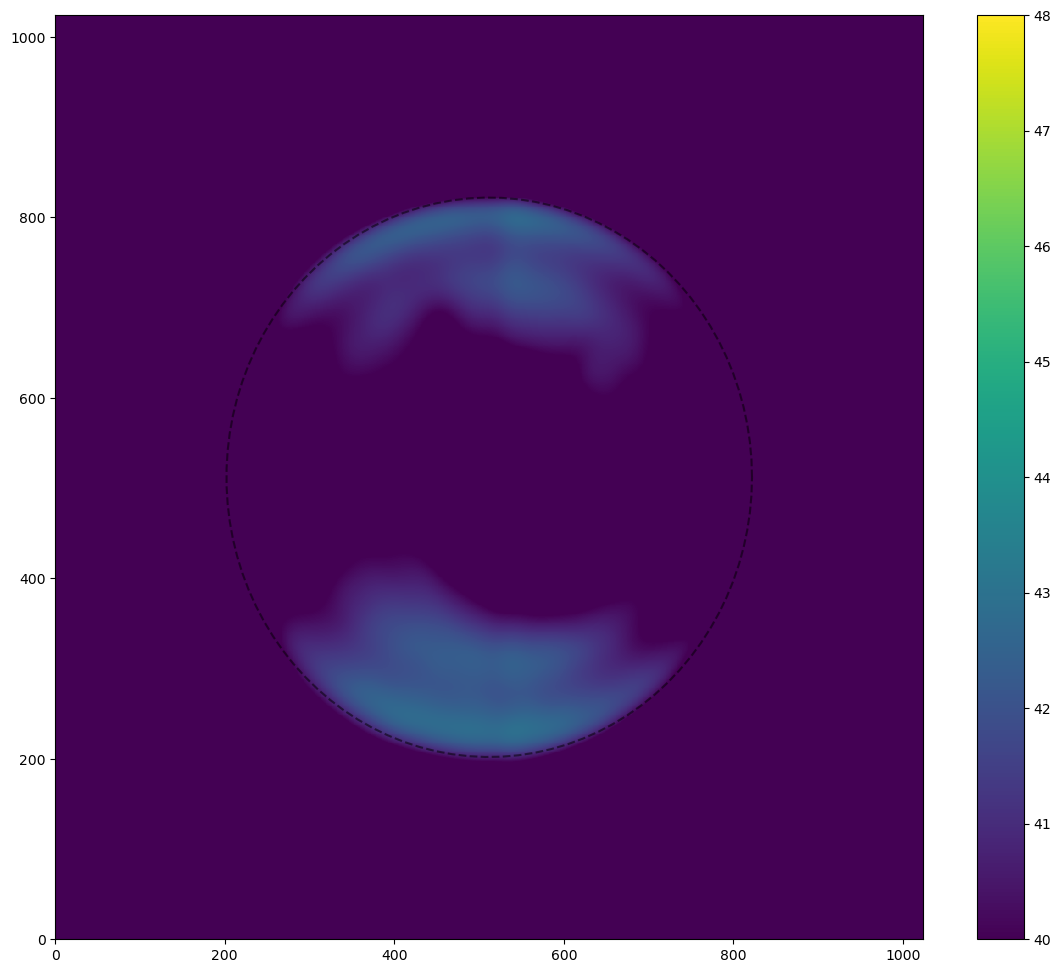

In [85]:
plt.figure(figsize = (14,12))
plt.pcolormesh(gf(mf(quads2*np.mean(imsM,axis = 0),20),10), vmin = 40, vmax = 48)
phis = np.linspace(0,360,100)*np.pi/180
plt.plot(512+ 310*np.cos(phis), 512+ 310*np.sin(phis), 'k--', alpha = 0.5)
plt.colorbar()

In [284]:
gfsig = 0. #0.9 
Ups = [0]
Bps = []
alphas = []
vNaxiss = []
alphaws = []
N_w = 6
N_t = 6
Nb = N_w*N_t
for i in range(len(Ups)):
    Np = 128
    Up = Ups[i]  
    filename = 'Bpbasis_Np' + str(Np) + '_Nw' + str(N_w) +'_Nt' + str(N_t) + '_Up' + str(Up)+'.npy'
    print(filename)
    br = np.load(basesdir+filename, allow_pickle=True)
    Breal = br[()]['Breal']
    Bimag = br[()]['Bimag']
    breal = br[()]['breal']
    bimag = br[()]['bimag']
    vNaxis = br[()]['vNaxis']
    alpha = br[()]['alpha']

    
    tempr = np.zeros((Breal.shape[0], 64**2))
    tempi = np.zeros((Breal.shape[0], 64**2))
    for i in range(len(Breal)):
        tempr[i,:] = np.reshape(rebin(np.reshape(Breal[i,:], [128,128])), [64**2])
        tempi[i,:] = np.reshape(rebin(np.reshape(Bimag[i,:], [128,128])), [64**2])

    Breal = tempr
    Bimag = tempi

    alphw = np.zeros(alpha['t_sample'].shape, dtype = complex)
    for i in range(len(alphw)):
        alphw[i] = np.fft.ifftshift(np.fft.ifft(alpha['t_sample'][i]))

    Np = 64
    for j in range(Breal.shape[0]):
        temp=np.reshape(Breal[j,:],[Np,Np])
        polimg = PR.cart2pol(temp,32,32)
        bb = np.zeros((64,64))
        bb[1:64,1:64]= PR.pol2cart(scimg.filters.gaussian_filter(polimg,[gfsig,0]))
        Breal[j,:]=np.reshape(bb,newshape=(1,Np**2))
        #temp=scimg.filters.gaussian_filter(temp,0.8889)
        #Bpr[j,:]=Variable(Tensor(np.reshape(temp,newshape=(1,Np**2))))
        temp=np.reshape(Bimag[j,:],[Np,Np])
        polimg = PR.cart2pol(temp,32,32)
        bb = np.zeros((64,64))
        bb[1:64,1:64]= PR.pol2cart(scimg.filters.gaussian_filter(polimg,[gfsig,0]))
        Bimag[j,:]=np.reshape(bb,newshape=(1,Np**2))
        #temp=scimg.filters.gaussian_filter(temp,0.8889)
        #Bpi[j,:]=Variable(Tensor(np.reshape(temp,newshape=(1,Np**2))))

    Bp_basis = Breal+1j*Bimag

    Bps.append(Bp_basis)
    alphas.append(alpha)
    vNaxiss.append(vNaxis)
    alphaws.append(alphw)

Bpbasis_Np128_Nw6_Nt6_Up0.npy


/tmp/ipykernel_29592/561546331.py:42: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  bb[1:64,1:64]= PR.pol2cart(scimg.filters.gaussian_filter(polimg,[gfsig,0]))
/tmp/ipykernel_29592/561546331.py:49: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  bb[1:64,1:64]= PR.pol2cart(scimg.filters.gaussian_filter(polimg,[gfsig,0]))


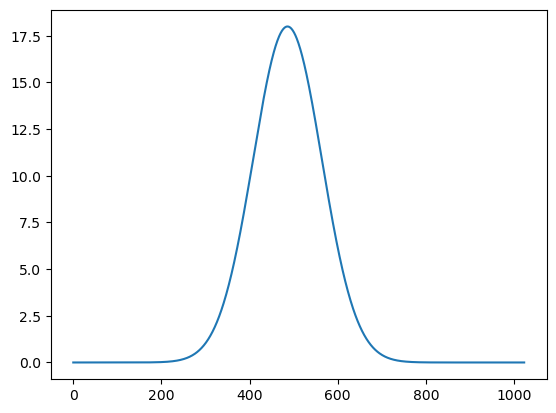

In [281]:
plt.plot(um)

In [288]:
n = 30

tocorim = []
tocoreV = []

quadrant_filters=[[1,0,0,0], [0,1,0,0], [0,0,1,0], [0,0,0,1], [1,1,1,1]]
ees = np.linspace(-9,9,n) #370,420
rrs0 = np.zeros((n,len(quadrant_filters)))
r1=260
r2 = 400
x0 = 512
y0 = 512

sss = um

for i in range(n):
    ee = ees[i]
    
    sss = fastsmooth1(sss,10)
    sss[sss<0] = 0

    spec = np.sqrt(sss)  #sqrt of intensity spectra to get E(w)
    pp =1200
    spec = np.pad(spec, (pp,), 'constant',constant_values=(0))
    N = len(spec)
    xeV = pix_2_eV(np.arange(N), pixpereV = 22, spectra_hw0 = 0, spectra_pix0 = pp+512)
    xeV = xeV + ee

    n1 = 0
    n2 = 3400 #want this to span 33.40369027550054 eV or less (range of vNaxis['w'])
                    #also need it to be centered around where you are calling zero or there will be an offset
    t1 = np.argmin((vNaxis['t_sample'] -vNaxis['t'][0])**2) 
    t2 = np.argmin((vNaxis['t_sample'] -vNaxis['t'][-1])**2)
    xeV = xeV[n1:n2]
    spec = spec[n1:n2] 
    spec = np.fft.fftshift(spec)

    f = interpolate.interp1d(xeV, spec, fill_value = 'extrapolate') #xeV is evenly spaced so this should be fine

    #sample more points from the relevant region
    NN = 1024
    NNN = 0
    N = len(spec)
    fx = interpolate.interp1d(np.arange(N), xeV, fill_value = 'extrapolate')
    xeV = fx(np.linspace(0-NNN, N-1+NNN, NN)) 
    spec = f(xeV) #evenly spaced
    xf = 2.9979E8*xeV/1239.84e-9

    f = xf[-1] - xf[0]
    N = len(spec)
    t = np.linspace(-N/f/2,N/f/2, N) 

    FFT = np.fft.fftshift(np.fft.fft(spec))
    car3 = np.exp(-1.j*(ee)/hbar*t)
    FFT = FFT*car3 #add in the frequency due to offset from zero frequency

    f = interpolate.interp1d(t, FFT, fill_value = 'extrapolate')
    x = f(vNaxis['t_sample'])
    alpha_t = alpha['t_sample']/np.max(np.abs(alpha['t_sample'])) #since we have shifted to right off zero frequency, do not add carrier to alpha

    Q = np.reshape(np.matmul(x, np.linalg.pinv(alpha_t)), [36,1])
    Msol1=np.real(np.matmul(np.matmul(Q,Q.conj().transpose()).transpose().flatten(),Bp_basis))


    #Msol1 =  make_bg_fixed(sss, ee, vNaxis0, alpha0, Bp_basis0, vls_pitch = 5.399977, order = 3)
    Msol1 = np.reshape(Msol1,[64,64])#, [int(np.sqrt(Msol1.shape[0])),int(np.sqrt(Msol1.shape[0]))]))
    ii = cv2.resize(np.rot90(Msol1), (1024,1024), interpolation = cv2.INTER_AREA)
    
    for j, qfilter in enumerate(quadrant_filters):
        
        folded = resizeFolded(foldQuadrant(ii, x0, y0, qfilter), 512)
        out = pbasex(folded, gData, make_images=True) #, weights = w) # the alpha is redundant here #weights

        ints = out['IE'].T #'IE' is the spectral intensity of the spectra, in KE. ints has shape (n_ims, n_KE_bins)
        betas = out['betas'][:,1].T # assymetry parameter, proj(L_2)/proj(L_0). same shape as ints
        spec_to_plot = ints[0] if len(ints.shape)==2 else ints
        
        centroid = get_centroidish(spec_to_plot[r1:r2])
        rrs0[i,j] = ke_calib(np.arange(r1,r2))[centroid]
    
        #rrs0[i,j] = ke_calib(np.arange(r1,r2))[np.argmax(spec_to_plot[r1:r2])]
    tocorim.append(ii)
    tocoreV.append(centroid)

         
    print(rrs0[i,:])

[306. 307. 307. 306. 306.]
[308. 308. 308. 307. 308.]
[309. 310. 310. 309. 309.]
[311. 312. 312. 310. 311.]
[313. 314. 313. 312. 313.]
[315. 315. 315. 314. 315.]
[317. 317. 317. 316. 317.]
[319. 319. 319. 318. 319.]
[321. 321. 321. 320. 321.]
[323. 324. 323. 322. 323.]
[325. 326. 325. 324. 325.]
[327. 328. 328. 327. 327.]
[329. 330. 330. 329. 329.]
[331. 332. 332. 331. 332.]
[334. 334. 333. 333. 334.]
[336. 336. 336. 335. 336.]
[337. 338. 338. 337. 338.]
[340. 340. 340. 339. 340.]
[342. 343. 342. 341. 342.]
[344. 345. 344. 343. 344.]
[346. 347. 346. 345. 346.]
[348. 348. 348. 347. 348.]
[350. 350. 350. 349. 349.]
[351. 352. 351. 351. 351.]
[353. 354. 353. 352. 353.]
[354. 355. 355. 354. 355.]
[356. 357. 356. 355. 356.]
[358. 358. 357. 357. 358.]
[359. 360. 359. 358. 359.]
[360. 361. 360. 359. 360.]


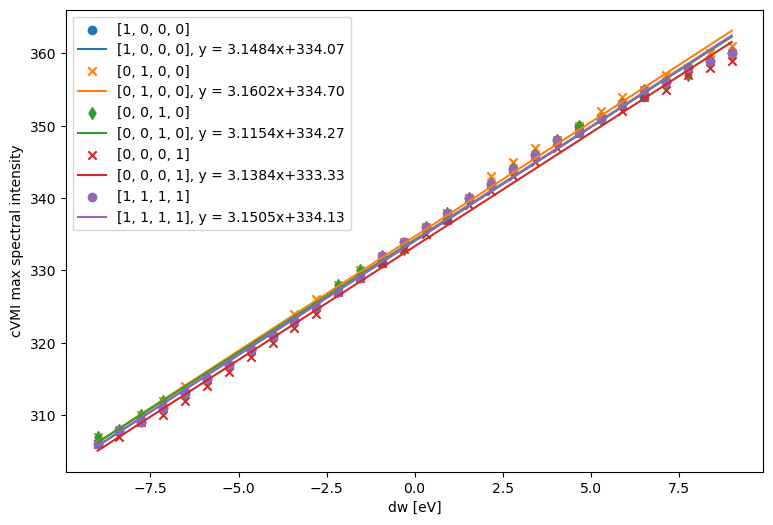

In [287]:
fig,axs = plt.subplots(figsize = (9,6))
plotstyle = ['o', 'x', 'd', 'x', 'o']
for j, qfilter in enumerate(quadrant_filters):
    plt.scatter(ees, rrs0[:,j], marker = plotstyle[j%5], label = qfilter)
    rplot = rrs0[:,j]
    eVplot = ees
    m,b = np.polyfit(eVplot,rplot, 1)
    eV = np.linspace(eVplot[0],eVplot[-1], 40)
    plt.plot(eV,m*eV+b, label = str(qfilter) + ', y = %1.4fx+%1.2f' %(m,b))
plt.xlabel('dw [eV]')
plt.ylabel('cVMI max spectral intensity')
plt.legend()

In [292]:

tocorim = np.array(tocorim)
y = np.array(tocoreV)
corcen = np.zeros((1024,1024))
for i in range(nn): #np.arange(150, 850): #range(1024):
    for j in range(nn): #np.arange(150,850): #in range(1024):
        try:
            x = np.array(tocorim[:,i,j])       
            corcen[i,j] = np.corrcoef(x,y)[0,1]
        except:
            corcen[i,j] = 0

/cds/sw/ds/ana/conda2/inst/envs/ps-4.5.23/lib/python3.9/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/cds/sw/ds/ana/conda2/inst/envs/ps-4.5.23/lib/python3.9/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Text(0.5, 1.0, 'simulated correlated with simulated centroid')

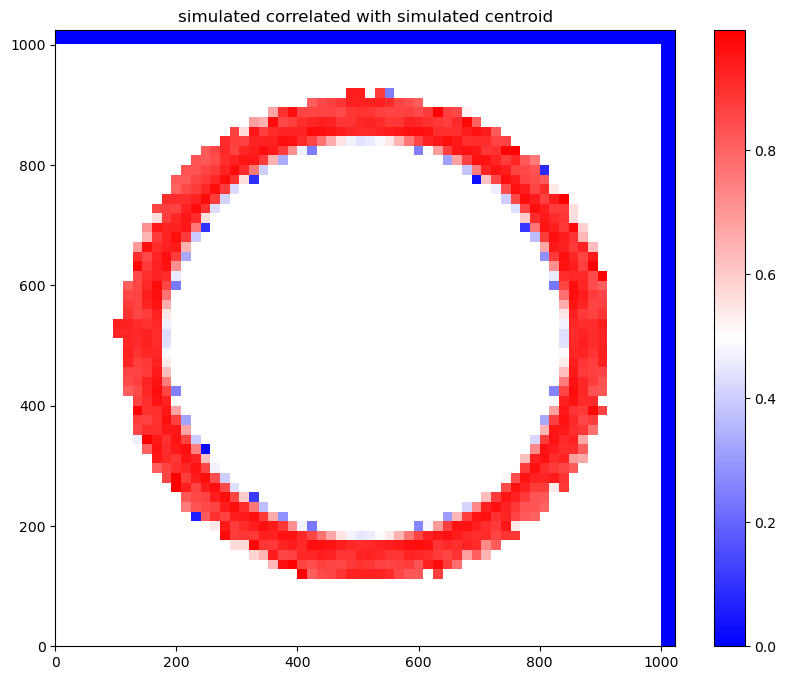

In [293]:
fig,axs = plt.subplots(figsize = (10,8))
toplot = np.copy(corcen)
toplot[toplot<0] = np.nan
plt.pcolormesh(toplot, cmap = 'bwr') #, vmin = 0, vmax = 0.2)
#plt.plot(512,870,'ro')
#plotring()
plt.colorbar()
#plt.title('vls pix = 400')
#plt.title('vls sum')
plt.title('simulated correlated with simulated centroid')
#plt.plot(np.arange(515,520),484+np.arange(280,285), 'r.')
#plt.title('centroid')
# plotring(r= 270, col = 'w')
# plotring(r= 310, col = 'w')

Text(0.5, 1.0, 'simulated correlated with simulated centroid')

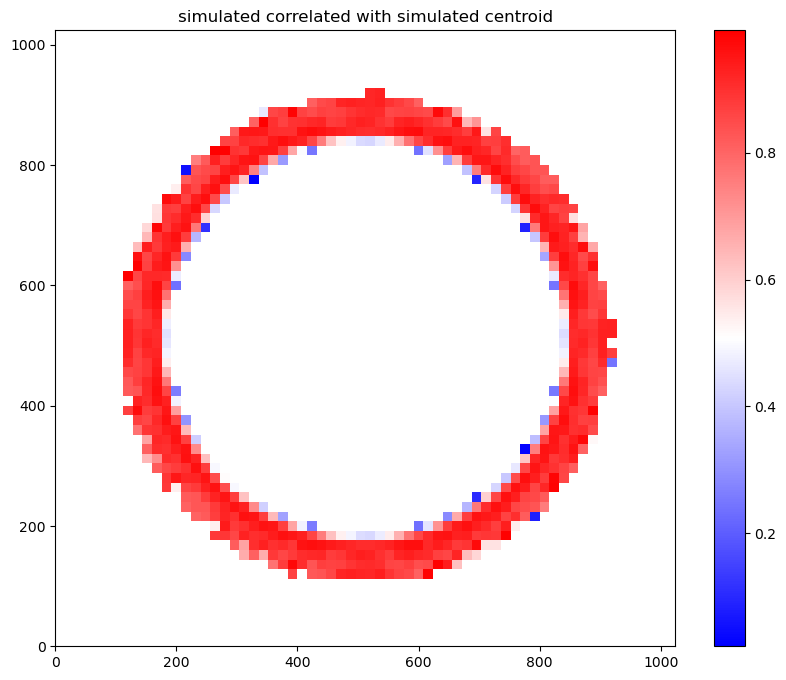

In [309]:
fig,axs = plt.subplots(figsize = (10,8))
toplot = np.copy(corcen)#[100:924,100:924]
toplot[toplot<0.001] = np.nan
plt.pcolormesh(np.rot90(toplot), cmap = 'bwr') #, vmin = 0, vmax = 0.2)
#plt.plot(512,870,'ro')
#plotring()
plt.colorbar()
#plt.title('vls pix = 400')
#plt.title('vls sum')
plt.title('simulated correlated with simulated centroid')
#plt.plot(np.arange(515,520),484+np.arange(280,285), 'r.')
#plt.title('centroid')
# plotring(r= 270, col = 'w')
# plotring(r= 310, col = 'w')

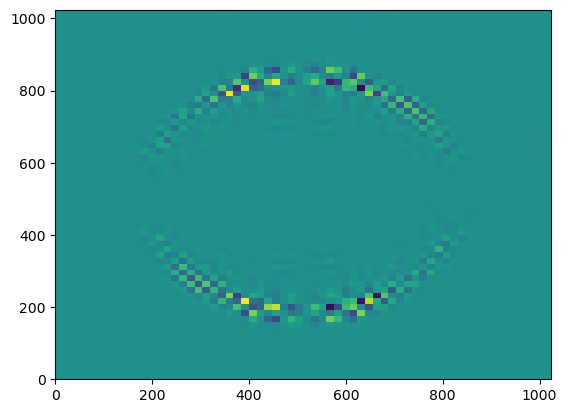

In [302]:
plt.pcolormesh(np.rot90(tocorim[10]-np.flip(tocorim[10])))


In [35]:
X,Y=np.meshgrid(np.arange(1024),np.arange(1024))
rs=np.sqrt((X-512)**2+(Y-512)**2)
maskhm=np.zeros((1024,1024))
#maskhm[(rs>325) & (rs<420)]=1
maskhm[(rs>325-42/2) & (rs<430+42/2)]=1

mask = rebin(rebin(maskhm,4),4)

In [92]:
1024/16

64.0

In [101]:
3.5*12

42.0

In [100]:
3.5*10/16

2.1875

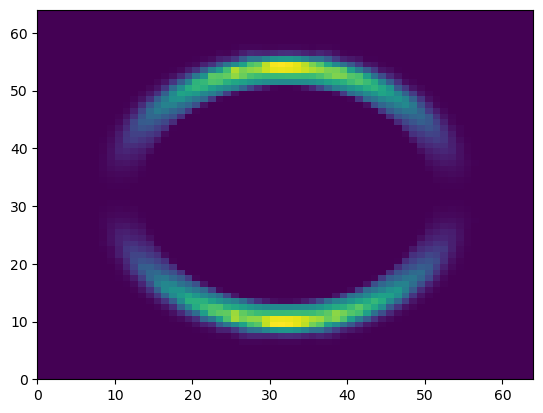

In [103]:
plt.pcolormesh(Msol1*mask)



In [260]:
ims_bg[0].shape

(1024, 1024)

In [36]:
pp =  cv2.warpPerspective(ims_bg[0]*quads2,MM,(1024,1024))

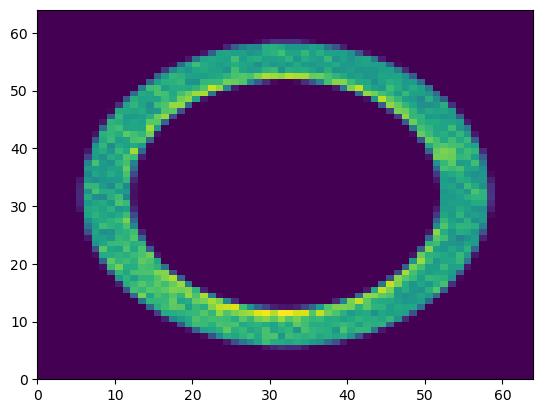

In [267]:
X,Y=np.meshgrid(np.arange(1024),np.arange(1024))
rs=np.sqrt((X-512)**2+(Y-512)**2)
maskhm=np.zeros((1024,1024))
maskhm[(rs>320) & (rs<420)]=1
#maskhm[(rs>325) & (rs<420)]=1
#maskhm[(rs>325-42/2) & (rs<430+42/2)]=1

mask = rebin(rebin(maskhm,4),4)
plt.pcolormesh(rebin(rebin(pp,4),4)*mask)

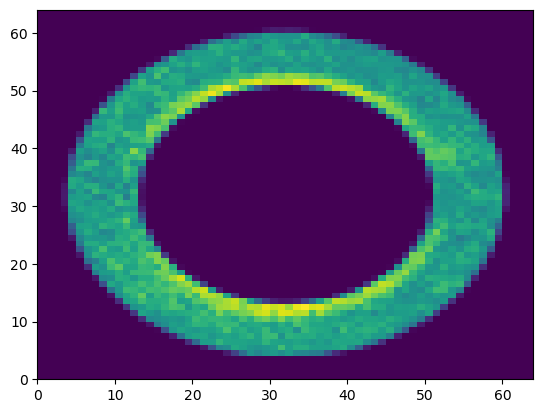

In [269]:
X,Y=np.meshgrid(np.arange(1024),np.arange(1024))
rs=np.sqrt((X-512)**2+(Y-512)**2)
maskhm=np.zeros((1024,1024))
#maskhm[(rs>325) & (rs<420)]=1
maskhm[(rs>325-42/2) & (rs<430+42/2)]=1

mask = rebin(rebin(maskhm,4),4)
plt.pcolormesh(rebin(rebin(pp,4),4)*mask)

In [39]:
325-42/2

304.0

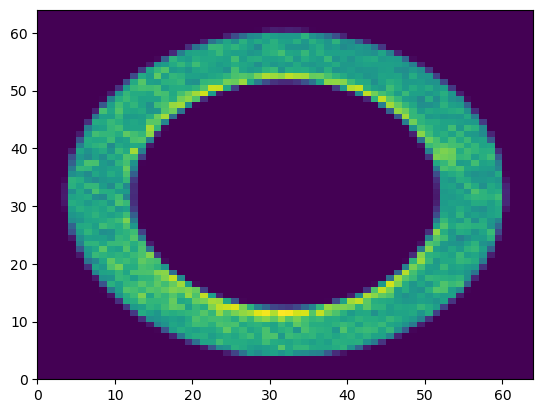

In [45]:
X,Y=np.meshgrid(np.arange(1024),np.arange(1024))
rs=np.sqrt((X-512)**2+(Y-512)**2)
maskhm=np.zeros((1024,1024))
maskhm[(rs>318) & (rs<430+42/2)]=1

mask = rebin(rebin(maskhm,4),4)
plt.pcolormesh(rebin(rebin(pp,4),4)*mask)

In [193]:
quadrant_filters=[[1,0,0,0], [0,1,0,0], [0,0,1,0], [0,0,0,1], [1,1,1,1]]
ees = np.zeros(36) #370,420
rrs0 = np.zeros((36,len(quadrant_filters)))
r1=260
r2 = 400
x0 = 512
y0 = 512
ke_calib = lambda x: x 

In [194]:
Msol1 = np.load('/cds/home/p/paris/reconVMI_clean/recon X510 Dec/Msol6.npy')
Msol1 = np.reshape(Msol1,[64,64])#, [int(np.sqrt(Msol1.shape[0])),int(np.sqrt(Msol1.shape[0]))]))
ii = cv2.resize(np.rot90(Msol1), (1024,1024), interpolation = cv2.INTER_AREA)

for j, qfilter in enumerate(quadrant_filters):

    folded = resizeFolded(foldQuadrant(ii, x0, y0, qfilter), 512)
    out = pbasex(folded, gData, make_images=True) #, weights = w) # the alpha is redundant here #weights

    ints = out['IE'].T #'IE' is the spectral intensity of the spectra, in KE. ints has shape (n_ims, n_KE_bins)
    betas = out['betas'][:,1].T # assymetry parameter, proj(L_2)/proj(L_0). same shape as ints
    spec_to_plot = ints[0] if len(ints.shape)==2 else ints

    centroid = get_centroidish(spec_to_plot[r1:r2])
    rrs0[j] = ke_calib(np.arange(r1,r2))[centroid]
    

print(rrs0)
print(np.mean(rrs0))

[327. 327. 327. 326. 327.]
326.8


Text(0.5, 1.0, 'Msol6 pBasex max pix = 326.8')

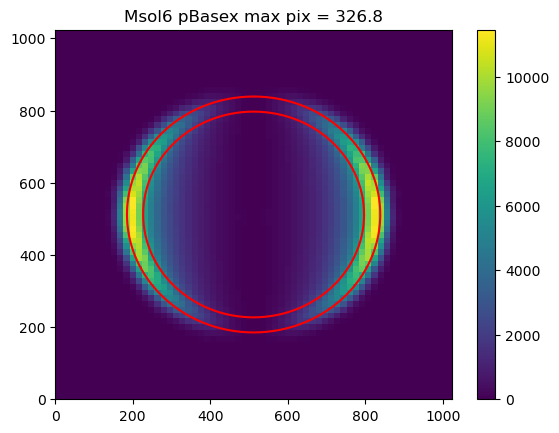

In [197]:
plt.pcolormesh(ii)
plt.colorbar()
r = 285
binn = 1
phi_rad = np.arange(0,360)*np.pi/180
plt.plot((512+r*np.cos(phi_rad))/binn, (512+r*np.sin(phi_rad))/binn, c='r')
r = 326.8
binn = 1
phi_rad = np.arange(0,360)*np.pi/180
plt.plot((512+r*np.cos(phi_rad))/binn, (512+r*np.sin(phi_rad))/binn, c='r')
plt.title('Msol6 pBasex max pix = %1.1f' %np.mean(rrs0))

In [228]:
n = 4

tocorim = []
tocoreV = []

quadrant_filters=[[1,0,0,0], [0,1,0,0], [0,0,1,0], [0,0,0,1], [1,1,1,1]]
ees = np.zeros(n) #370,420
rrs0 = np.zeros((n,len(quadrant_filters)))
r1=260
r2 = 400
x0 = 512
y0 = 512

for i in range(n):
    
    Q = np.zeros((36,1), complex)
    Q[i] = (-0.7+0.5j)
    Q[i+1] = (0.8-0.5j)
    Q[i+2] = (-0.7+0.5j)
    
    Msol1=np.real(np.matmul(np.matmul(Q,Q.conj().transpose()).transpose().flatten(),Bp_basis))

    
    N = 2801
    xf = np.arange(-N/2+1/2,N/2+1/2,1)/((vNaxis['t_sample'][-1] - vNaxis['t_sample'][0])) #using tsample range
    eV = 1239.84*(2*np.pi*xf)/2.9979E8/(2*np.pi)*1e-9 
    Ew = np.squeeze(np.matmul(Q.T,alphw))
    EwEw = np.real(Ew*Ew.conj())
    EwEw = EwEw[1340:-1340]
    EwEw = EwEw/np.max(EwEw)
    #ees[i] = eV[1340:-1340][np.argmax(EwEw)]
    ees[i] = eV[1340:-1340][get_centroidish(EwEw)]
    
    #Msol1 =  make_bg_fixed(sss, ee, vNaxis0, alpha0, Bp_basis0, vls_pitch = 5.399977, order = 3)
    Msol1 = np.reshape(Msol1,[64,64])#, [int(np.sqrt(Msol1.shape[0])),int(np.sqrt(Msol1.shape[0]))]))
    ii = cv2.resize(np.rot90(Msol1), (1024,1024), interpolation = cv2.INTER_AREA)
    
    for j, qfilter in enumerate(quadrant_filters):
        
        folded = resizeFolded(foldQuadrant(ii, x0, y0, qfilter), 512)
        out = pbasex(folded, gData, make_images=True) #, weights = w) # the alpha is redundant here #weights

        ints = out['IE'].T #'IE' is the spectral intensity of the spectra, in KE. ints has shape (n_ims, n_KE_bins)
        betas = out['betas'][:,1].T # assymetry parameter, proj(L_2)/proj(L_0). same shape as ints
        spec_to_plot = ints[0] if len(ints.shape)==2 else ints
        
        centroid = get_centroidish(spec_to_plot[r1:r2])
        rrs0[i,j] = ke_calib(np.arange(r1,r2))[centroid]
        

    
        #rrs0[i,j] = ke_calib(np.arange(r1,r2))[np.argmax(spec_to_plot[r1:r2])]
    tocorim.append(ii)
    tocoreV.append(centroid)

         
    print(rrs0[i,:])

[352. 353. 352. 351. 352.]
[340. 340. 340. 339. 340.]
[327. 328. 328. 327. 327.]
[314. 315. 314. 313. 314.]


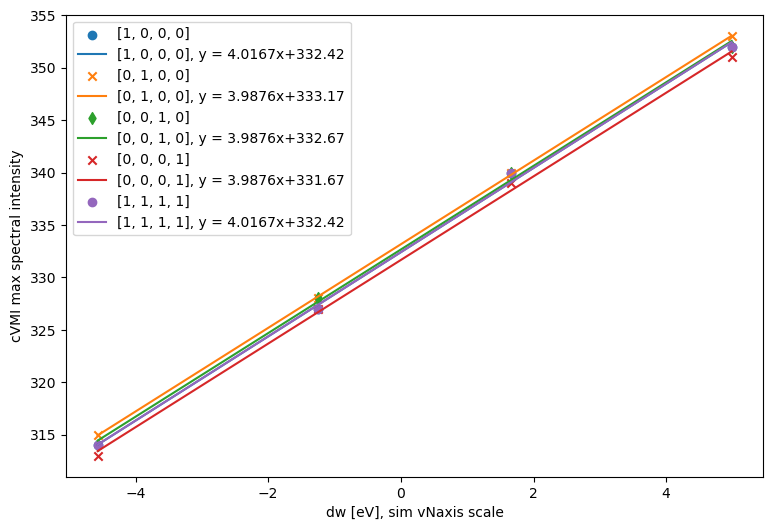

In [230]:
fig,axs = plt.subplots(figsize = (9,6))
plotstyle = ['o', 'x', 'd', 'x', 'o']
for j, qfilter in enumerate(quadrant_filters):
    plt.scatter(ees, rrs0[:,j], marker = plotstyle[j%5], label = qfilter)
    rplot = rrs0[:,j]
    eVplot = ees
    m,b = np.polyfit(eVplot,rplot, 1)
    eV = np.linspace(eVplot[0],eVplot[-1], 40)
    plt.plot(eV,m*eV+b, label = str(qfilter) + ', y = %1.4fx+%1.2f' %(m,b))
plt.xlabel('dw [eV], sim vNaxis scale')
plt.ylabel('cVMI max spectral intensity')
plt.legend()